In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from pathlib import Path
import shutil
from tqdm import tqdm
import pickle

BTAD 데이터셋에서 샘플 이미지 로드 중...
OK 이미지 로드: /mnt/d/BTech_Dataset_transformed/01/test/ok/0000.bmp
KO 이미지 로드: /mnt/d/BTech_Dataset_transformed/01/test/ko/0000.bmp
OK 이미지 크기: (1600, 1600)
KO 이미지 크기: (1600, 1600)

=== OK 이미지 통계 ===
평균 밝기: 124.04
표준편차: 98.11
최솟값: 0
최댓값: 255
R 채널 - 평균: 81.41, 표준편차: 87.14
G 채널 - 평균: 158.38, 표준편차: 117.66
B 채널 - 평균: 132.34, 표준편차: 66.12

=== KO 이미지 통계 ===
평균 밝기: 127.47
표준편차: 93.61
최솟값: 0
최댓값: 255
R 채널 - 평균: 73.55, 표준편차: 70.89
G 채널 - 평균: 168.29, 표준편차: 118.52
B 채널 - 평균: 140.57, 표준편차: 49.72

전처리 효과 시각화 중...


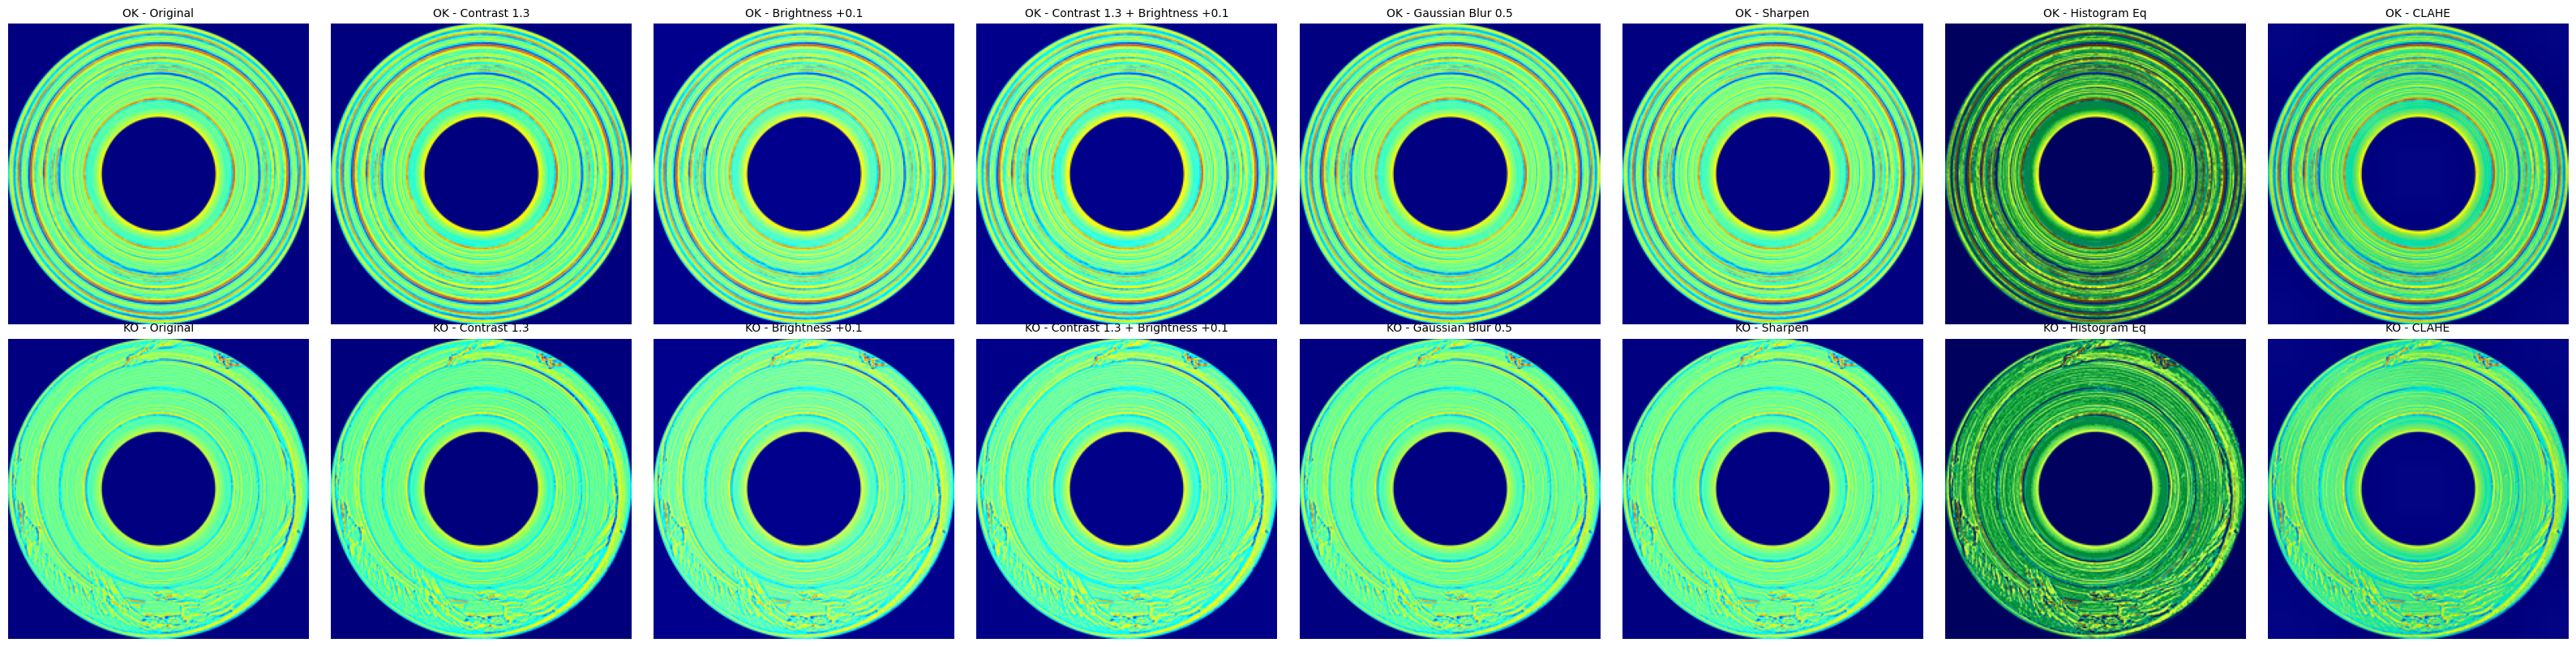


=== 전처리별 통계 변화 ===

--- Original ---
OK 평균 밝기: 123.83
KO 평균 밝기: 127.41
밝기 차이: 3.58

--- Contrast 1.3 ---
OK 평균 밝기: 123.37
KO 평균 밝기: 126.15
밝기 차이: 2.78

--- Brightness +0.1 ---
OK 평균 밝기: 129.86
KO 평균 밝기: 133.94
밝기 차이: 4.08

--- Contrast 1.3 + Brightness +0.1 ---
OK 평균 밝기: 128.60
KO 평균 밝기: 132.07
밝기 차이: 3.47


In [51]:
data_path = "/mnt/d/BTech_Dataset_transformed"
product = "01"

def load_sample_images(data_path, product="01"):
    """OK와 KO 샘플 이미지를 하나씩 로드"""
    base_path = Path(data_path) / product
    
    # OK 이미지 찾기
    ok_path = base_path / "test" / "ok"
    ok_files = list(ok_path.glob("*.bmp")) + list(ok_path.glob("*.png"))
    
    # KO 이미지 찾기 (첫 번째 결함 타입)
    test_path = base_path / "test"
    ko_dirs = [d for d in test_path.iterdir() if d.is_dir() and d.name != "ok"]
    
    if ko_dirs:
        ko_path = ko_dirs[0]  # 첫 번째 결함 타입
        ko_files = list(ko_path.glob("*.bmp")) + list(ko_path.glob("*.png"))
    else:
        ko_files = []
    
    ok_image = None
    ko_image = None
    
    if ok_files:
        ok_image = Image.open(ok_files[0]).convert("RGB")
        print(f"OK 이미지 로드: {ok_files[0]}")
    
    if ko_files:
        ko_image = Image.open(ko_files[0]).convert("RGB")
        print(f"KO 이미지 로드: {ko_files[0]}")
    
    return ok_image, ko_image

def apply_contrast_brightness(image, contrast=1.0, brightness=0):
    """대비와 밝기 조정"""
    if contrast != 1.0:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(contrast)
    
    if brightness != 0:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(1.0 + brightness)
    
    return image

def apply_gaussian_blur(image, radius=1.0):
    """가우시안 블러 적용"""
    return image.filter(ImageFilter.GaussianBlur(radius=radius))

def apply_sharpen(image):
    """이미지 선명도 향상"""
    return image.filter(ImageFilter.SHARPEN)

def apply_histogram_equalization(image):
    """히스토그램 평활화"""
    # PIL을 OpenCV로 변환
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    # LAB 색공간으로 변환
    lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    
    # L 채널에 히스토그램 평활화 적용
    lab[:,:,0] = cv2.equalizeHist(lab[:,:,0])
    
    # 다시 RGB로 변환
    img_eq = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_eq = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    
    return Image.fromarray(img_eq)

def apply_clahe(image, clip_limit=2.0):
    """CLAHE (Contrast Limited Adaptive Histogram Equalization) 적용"""
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    
    # CLAHE 객체 생성
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
    
    return Image.fromarray(img_clahe)

def resize_image(image, size=224):
    """이미지 리사이즈 (PatchCore 입력 크기에 맞춤)"""
    return image.resize((size, size), Image.Resampling.LANCZOS)

def visualize_preprocessing_effects(ok_image, ko_image):
    """전처리 효과를 시각화"""
    
    # 전처리 설정들
    preprocessing_configs = [
        {"name": "Original", "func": lambda x: x},
        {"name": "Contrast 1.3", "func": lambda x: apply_contrast_brightness(x, contrast=1.3)},
        {"name": "Brightness +0.1", "func": lambda x: apply_contrast_brightness(x, brightness=0.1)},
        {"name": "Contrast 1.3 + Brightness +0.1", "func": lambda x: apply_contrast_brightness(x, contrast=1.3, brightness=0.1)},
        {"name": "Gaussian Blur 0.5", "func": lambda x: apply_gaussian_blur(x, radius=0.5)},
        {"name": "Sharpen", "func": lambda x: apply_sharpen(x)},
        {"name": "Histogram Eq", "func": lambda x: apply_histogram_equalization(x)},
        {"name": "CLAHE", "func": lambda x: apply_clahe(x, clip_limit=2.0)},
    ]
    
    n_configs = len(preprocessing_configs)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    for i, config in enumerate(preprocessing_configs):
        # OK 이미지 처리
        ok_processed = config["func"](ok_image.copy())
        ok_resized = resize_image(ok_processed, 224)
        
        # KO 이미지 처리
        ko_processed = config["func"](ko_image.copy())
        ko_resized = resize_image(ko_processed, 224)
        
        # 시각화
        axes[0, i].imshow(ok_resized)
        axes[0, i].set_title(f'OK - {config["name"]}', fontsize=10)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(ko_resized)
        axes[1, i].set_title(f'KO - {config["name"]}', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return preprocessing_configs

def analyze_image_statistics(image, title=""):
    """이미지 통계 분석"""
    img_array = np.array(image)
    
    print(f"\n=== {title} 이미지 통계 ===")
    print(f"평균 밝기: {np.mean(img_array):.2f}")
    print(f"표준편차: {np.std(img_array):.2f}")
    print(f"최솟값: {np.min(img_array)}")
    print(f"최댓값: {np.max(img_array)}")
    
    # RGB 채널별 통계
    for i, channel in enumerate(['R', 'G', 'B']):
        channel_data = img_array[:,:,i]
        print(f"{channel} 채널 - 평균: {np.mean(channel_data):.2f}, 표준편차: {np.std(channel_data):.2f}")

# 1. 샘플 이미지 로드
print("BTAD 데이터셋에서 샘플 이미지 로드 중...")
ok_img, ko_img = load_sample_images(data_path, product)

if ok_img is None or ko_img is None:
    print("이미지를 로드할 수 없습니다. 데이터 경로를 확인해주세요.")
    print("data_path 변수를 실제 BTAD 데이터셋 경로로 수정해주세요.")
else:
    print(f"OK 이미지 크기: {ok_img.size}")
    print(f"KO 이미지 크기: {ko_img.size}")
    
    # 2. 원본 이미지 통계 분석
    analyze_image_statistics(ok_img, "OK")
    analyze_image_statistics(ko_img, "KO")
    
    # 3. 전처리 효과 시각화
    print("\n전처리 효과 시각화 중...")
    configs = visualize_preprocessing_effects(ok_img, ko_img)
    
    # 4. 각 전처리별 통계 분석 (옵션)
    print("\n=== 전처리별 통계 변화 ===")
    for config in configs[:4]:  # 주요 전처리만
        ok_processed = resize_image(config["func"](ok_img.copy()), 224)
        ko_processed = resize_image(config["func"](ko_img.copy()), 224)
        
        print(f"\n--- {config['name']} ---")
        ok_stats = np.array(ok_processed)
        ko_stats = np.array(ko_processed)
        
        print(f"OK 평균 밝기: {np.mean(ok_stats):.2f}")
        print(f"KO 평균 밝기: {np.mean(ko_stats):.2f}")
        print(f"밝기 차이: {np.mean(ko_stats) - np.mean(ok_stats):.2f}")
        

In [65]:
def apply_brightness(image, brightness=0.1):
    """밝기 조정"""
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(1.0 + brightness)

def apply_histogram_equalization(image):
    """히스토그램 평활화"""
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    lab[:,:,0] = cv2.equalizeHist(lab[:,:,0])
    img_eq = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_eq = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_eq)

def apply_clahe(image, clip_limit=2.0):
    """CLAHE 적용"""
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_clahe)

def create_preprocessed_dataset_simple(source_path, target_path, preprocessing_type="brightness"):
    """전체 데이터셋에 전처리 적용 (ground_truth 제외)"""
    
    preprocessing_funcs = {
        "brightness": lambda img: apply_brightness(img, brightness=0.1),
        "histogram_eq": lambda img: apply_histogram_equalization(img),
        "clahe": lambda img: apply_clahe(img, clip_limit=2.0)
    }
    
    if preprocessing_type not in preprocessing_funcs:
        raise ValueError(f"지원하지 않는 전처리 타입: {preprocessing_type}")
    
    preprocess_func = preprocessing_funcs[preprocessing_type]
    
    source_root = Path(source_path)
    target_root = Path(target_path)
    
    # 대상 폴더 생성
    target_root.mkdir(parents=True, exist_ok=True)
    
    # 처리할 폴더들 (train/test)
    splits = ["train", "test"]
    
    total_files = 0
    processed_files = 0
    
    # 전체 파일 수 계산
    for split in splits:
        split_path = source_root / split
        if split_path.exists():
            for class_dir in split_path.iterdir():
                if class_dir.is_dir():
                    image_files = list(class_dir.glob("*.bmp")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpg"))
                    total_files += len(image_files)
    
    print(f"총 {total_files}개 파일 처리 시작...")
    
    # 각 split (train/test) 처리
    for split in splits:
        split_path = source_root / split
        if not split_path.exists():
            continue
            
        target_split_path = target_root / split
        target_split_path.mkdir(exist_ok=True)
        
        # 각 클래스 폴더 처리 (ok, ko 등)
        for class_dir in split_path.iterdir():
            if not class_dir.is_dir():
                continue
                
            class_name = class_dir.name
            target_class_path = target_split_path / class_name
            target_class_path.mkdir(exist_ok=True)
            
            # 이미지 파일들 처리
            image_files = list(class_dir.glob("*.bmp")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpg"))
            
            for img_file in tqdm(image_files, desc=f"Processing {split}/{class_name}"):
                try:
                    # 이미지 로드
                    image = Image.open(img_file).convert("RGB")
                    
                    # 전처리 적용
                    processed_image = preprocess_func(image)
                    
                    # 저장 (원본과 같은 이름)
                    target_file = target_class_path / img_file.name
                    processed_image.save(target_file)
                    
                    processed_files += 1
                    
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
    
    print(f"완료! {processed_files}/{total_files} 파일 처리됨")
    print(f"결과 저장 위치: {target_path}")
    print("Note: ground_truth 폴더는 권한 문제로 복사하지 않았습니다.")

def create_one_preprocessing(base_source_path, base_target_path, folder_name, preprocessing_type):
    """단일 전처리 버전 생성"""
    print(f"\n{'='*50}")
    print(f"Creating {folder_name} with {preprocessing_type} preprocessing...")
    print(f"{'='*50}")
    
    target_path = os.path.join(base_target_path, folder_name)
    create_preprocessed_dataset_simple(base_source_path, target_path, preprocessing_type)

def create_all_preprocessing_simple(base_source_path, base_target_path):
    """3가지 전처리 버전을 모두 생성 (간단 버전)"""
    
    preprocessing_configs = [
        ("03_brightness", "brightness"),
        ("04_histogram_eq", "histogram_eq"), 
        ("05_clahe", "clahe")
    ]
    
    for folder_name, preprocessing_type in preprocessing_configs:
        create_one_preprocessing(base_source_path, base_target_path, folder_name, preprocessing_type)
    
    print(f"\n{'='*50}")
    print("모든 전처리 완료!")
    print("생성된 폴더들:")
    print("- 03_brightness: 밝기 +0.1 버전")
    print("- 04_histogram_eq: 히스토그램 평활화 버전")  
    print("- 05_clahe: CLAHE 버전")
    print("이제 각 폴더로 PatchCore 훈련/테스트를 진행하세요!")
    print(f"{'='*50}")

base_source = "/mnt/d/BTech_Dataset_transformed/01"
base_target = "/mnt/d/BTech_Dataset_transformed"

# 1. 밝기 조정
create_one_preprocessing(base_source, base_target, "03_brightness", "brightness")

# 2. 히스토그램 평활화
create_one_preprocessing(base_source, base_target, "04_histogram_eq", "histogram_eq")

# 3. CLAHE
create_one_preprocessing(base_source, base_target, "05_clahe", "clahe")


Creating 03_brightness with brightness preprocessing...
총 470개 파일 처리 시작...


Processing test/ok: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


완료! 470/470 파일 처리됨
결과 저장 위치: /mnt/d/BTech_Dataset_transformed/03_brightness
Note: ground_truth 폴더는 권한 문제로 복사하지 않았습니다.

Creating 04_histogram_eq with histogram_eq preprocessing...
총 470개 파일 처리 시작...


Processing test/ok: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


완료! 470/470 파일 처리됨
결과 저장 위치: /mnt/d/BTech_Dataset_transformed/04_histogram_eq
Note: ground_truth 폴더는 권한 문제로 복사하지 않았습니다.

Creating 05_clahe with clahe preprocessing...
총 470개 파일 처리 시작...


Processing test/ok: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]

완료! 470/470 파일 처리됨
결과 저장 위치: /mnt/d/BTech_Dataset_transformed/05_clahe
Note: ground_truth 폴더는 권한 문제로 복사하지 않았습니다.


In [71]:
scores_path = "/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_224_WR50_L2-3/segmentation_images/btad_01/scores.npy"

if os.path.exists(scores_path):
    scores = np.load(scores_path)
    print(f"Shape: {scores.shape}, 데이터 타입: {scores.dtype}")
    print(f"최솟값: {scores.min():.4f}, 최댓값: {scores.max():.4f}")
    print(f"처음 10개: {scores[:10]}")
else:
    print("파일이 없습니다.")
    
# 폴더 내 파일 목록
folder_path = "/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_224_WR50_L2-3/segmentation_images/btad_01/"
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(f"폴더 내 파일들: {files}")

Shape: (70,), 데이터 타입: float32
최솟값: 0.0000, 최댓값: 1.0000
처음 10개: [0.67745    0.89499557 0.30206224 0.18345022 0.42379743 0.7484401
 0.9783482  0.86935306 0.77534    0.27090847]
폴더 내 파일들: ['01_test_ko_0001_KO_vs_Anomaly_CORRECT.png', '01_test_ok_0020_OK_vs_Normal_CORRECT.png', '01_test_ok_0014_OK_vs_Normal_CORRECT.png', '01_test_ko_0003_KO_vs_Normal_WRONG.png', '01_test_ko_0034_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0036_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0016_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0007_KO_vs_Anomaly_CORRECT.png', '01_test_ok_0013_OK_vs_Normal_CORRECT.png', '01_test_ko_0023_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0049_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0006_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0030_KO_vs_Normal_WRONG.png', '01_test_ko_0026_KO_vs_Anomaly_CORRECT.png', '01_test_ok_0018_OK_vs_Normal_CORRECT.png', '01_test_ko_0045_KO_vs_Normal_WRONG.png', '01_test_ko_0041_KO_vs_Anomaly_CORRECT.png', '01_test_ko_0044_KO_vs_Anomaly_CORRECT.png', '01_test_ok_0016_

Original (224): 70개 점수 로드 완료


/tmp/ipykernel_938/1955127114.py:139: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1955127114.py:139: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1955127114.py:139: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
/home/lkmsdf159/miniconda3/envs/patchcore/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lkmsdf159/miniconda3/envs/patchcore/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lkmsdf159/miniconda3/envs/patchcore/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE D

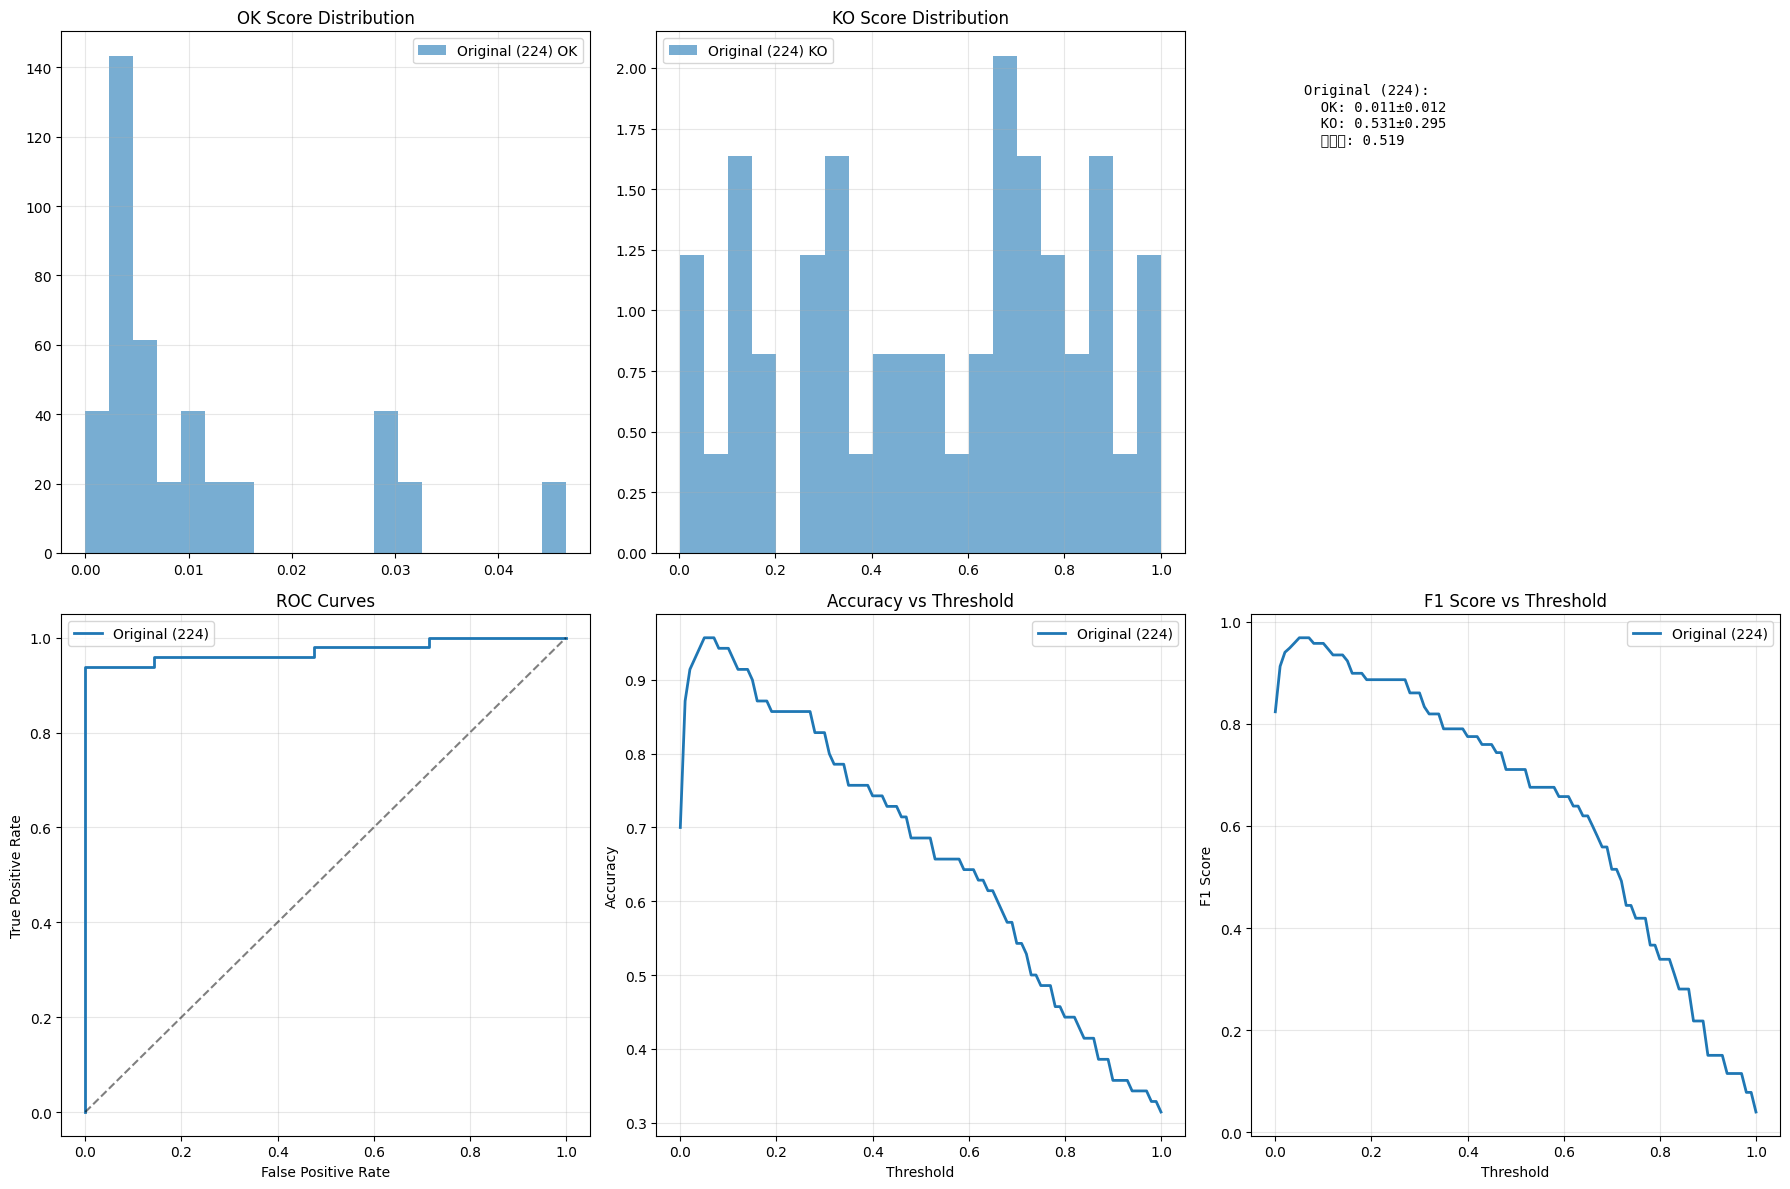


Threshold 0.2에서의 성능 비교:
--------------------------------------------------------------------------------
                accuracy  precision  recall      f1    tp    tn   fp    fn
Original (224)    0.8571        1.0  0.7959  0.8864  39.0  21.0  0.0  10.0

최고 성능:
accuracy: Original (224) (0.8571)
f1: Original (224) (0.8864)
recall: Original (224) (0.7959)


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import roc_curve

def load_real_scores(results_base_path):
    experiments = {
        'Original (224)': 'BTAD01_224_WR50_L2-3',
        'Brightness +0.1': 'BTAD_brightness_224_WR50_L2-3', 
        'Histogram Eq': 'BTAD_histogram_224_WR50_L2-3',
        'CLAHE': 'BTAD_clahe_224_WR50_L2-3'
    }
    
    all_data = {}
    
    for exp_name, folder_name in experiments.items():
        scores_path = os.path.join(results_base_path, folder_name, "segmentation_images/btad_01/scores.npy")
        folder_path = os.path.join(results_base_path, folder_name, "segmentation_images/btad_01/")
        
        if os.path.exists(scores_path) and os.path.exists(folder_path):
            scores = np.load(scores_path)
            files = sorted(os.listdir(folder_path))
            png_files = [f for f in files if f.endswith('.png')]
            
            labels = []
            for file in png_files:
                if "_OK_" in file:
                    labels.append(0)
                elif "_KO_" in file:
                    labels.append(1)
            
            if len(scores) == len(labels):
                all_data[exp_name] = {'scores': scores, 'labels': np.array(labels)}
                print(f"{exp_name}: {len(scores)}개 점수 로드 완료")
            else:
                print(f"{exp_name}: 점수와 레이블 개수 불일치")
    
    return all_data

def analyze_threshold_performance(scores, labels, thresholds):
    results = []
    for t in thresholds:
        predictions = (scores >= t).astype(int)
        tp = np.sum((predictions == 1) & (labels == 1))
        tn = np.sum((predictions == 0) & (labels == 0))
        fp = np.sum((predictions == 1) & (labels == 0))
        fn = np.sum((predictions == 0) & (labels == 1))
        
        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': t, 'accuracy': accuracy, 'precision': precision,
            'recall': recall, 'f1': f1, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        })
    
    return pd.DataFrame(results)

def create_analysis_plots(all_data):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 분석할 threshold 범위
    test_thresholds = np.linspace(0.0, 1.0, 101)
    
    threshold_02_results = {}
    
    for i, (exp_name, data) in enumerate(all_data.items()):
        scores = data['scores']
        labels = data['labels']
        
        ok_scores = scores[labels == 0]
        ko_scores = scores[labels == 1]
        
        # 1. 점수 분포
        axes[0,0].hist(ok_scores, bins=20, alpha=0.6, label=f'{exp_name} OK', density=True)
        axes[0,1].hist(ko_scores, bins=20, alpha=0.6, label=f'{exp_name} KO', density=True)
        
        # threshold 0.2에서의 성능
        threshold_02_perf = analyze_threshold_performance(scores, labels, [0.2])
        threshold_02_results[exp_name] = threshold_02_perf.iloc[0]
        
        # ROC 곡선
        fpr, tpr, roc_thresholds = roc_curve(labels, scores)
        axes[1,0].plot(fpr, tpr, label=f'{exp_name}', linewidth=2)
        
        # Threshold별 성능
        perf_df = analyze_threshold_performance(scores, labels, test_thresholds)
        axes[1,1].plot(test_thresholds, perf_df['accuracy'], label=f'{exp_name}', linewidth=2)
        axes[1,2].plot(test_thresholds, perf_df['f1'], label=f'{exp_name}', linewidth=2)
    
    # 그래프 설정
    axes[0,0].set_title('OK Score Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].set_title('KO Score Distribution') 
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    axes[1,0].plot([0,1], [0,1], 'k--', alpha=0.5)
    axes[1,0].set_title('ROC Curves')
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].set_title('Accuracy vs Threshold')
    axes[1,1].set_xlabel('Threshold')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    axes[1,2].set_title('F1 Score vs Threshold')
    axes[1,2].set_xlabel('Threshold')
    axes[1,2].set_ylabel('F1 Score')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    # 통계 표시
    axes[0,2].axis('off')
    stat_text = ""
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        ok_scores = scores[labels == 0]
        ko_scores = scores[labels == 1]
        
        stat_text += f"{exp_name}:\n"
        stat_text += f"  OK: {ok_scores.mean():.3f}±{ok_scores.std():.3f}\n"
        stat_text += f"  KO: {ko_scores.mean():.3f}±{ko_scores.std():.3f}\n"
        stat_text += f"  분리도: {ko_scores.mean() - ok_scores.mean():.3f}\n\n"
    
    axes[0,2].text(0.1, 0.9, stat_text, transform=axes[0,2].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return threshold_02_results

def print_threshold_02_results(threshold_02_results):
    print("\nThreshold 0.2에서의 성능 비교:")
    print("-" * 80)
    
    df = pd.DataFrame(threshold_02_results).T
    df = df[['accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn']]
    df = df.round(4)
    
    print(df)
    
    print("\n최고 성능:")
    for metric in ['accuracy', 'f1', 'recall']:
        best_exp = df[metric].idxmax()
        best_val = df[metric].max()
        print(f"{metric}: {best_exp} ({best_val:.4f})")

# 실행
results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"
all_data = load_real_scores(results_base_path)

if all_data:
    threshold_02_results = create_analysis_plots(all_data)
    print_threshold_02_results(threshold_02_results)
else:
    print("데이터를 찾을 수 없습니다.")

확인 중: /home/lkmsdf159/patchcore-inspection/results/project/BTAD01_224_WR50_L2-3/segmentation_images/btad_01/scores.npy
✅ Original (224): 70개 점수 로드
확인 중: /home/lkmsdf159/patchcore-inspection/results/project/BTAD_brightness_224_WR50_L2-3/segmentation_images/btad_03_brightness/scores.npy
✅ Brightness +0.1: 70개 점수 로드
확인 중: /home/lkmsdf159/patchcore-inspection/results/project/BTAD_histogram_224_WR50_L2-3/segmentation_images/btad_04_histogram_eq/scores.npy
✅ Histogram Eq: 70개 점수 로드
확인 중: /home/lkmsdf159/patchcore-inspection/results/project/BTAD_clahe_224_WR50_L2-3/segmentation_images/btad_05_clahe/scores.npy
✅ CLAHE: 70개 점수 로드

모든 전처리 Threshold 0.2에서의 성능 비교:
--------------------------------------------------------------------------------
                 accuracy  precision  recall      f1    tp    tn   fp    fn
Original (224)     0.8571        1.0  0.7959  0.8864  39.0  21.0  0.0  10.0
Brightness +0.1    0.8857        1.0  0.8367  0.9111  41.0  21.0  0.0   8.0
Histogram Eq       0.8714     

/tmp/ipykernel_938/4211463864.py:183: UserWarning: Glyph 45459 (\N{HANGUL SYLLABLE NOH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4211463864.py:183: UserWarning: Glyph 52828 (\N{HANGUL SYLLABLE CIN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4211463864.py:183: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4211463864.py:183: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4211463864.py:183: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4211463864.py:183: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from current font.
  plt.tight_layout()
/home/lkmsdf159/miniconda3/envs/patchcore/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45459 (\N{HANGUL SYLLABLE NOH}) missing from current font.
 

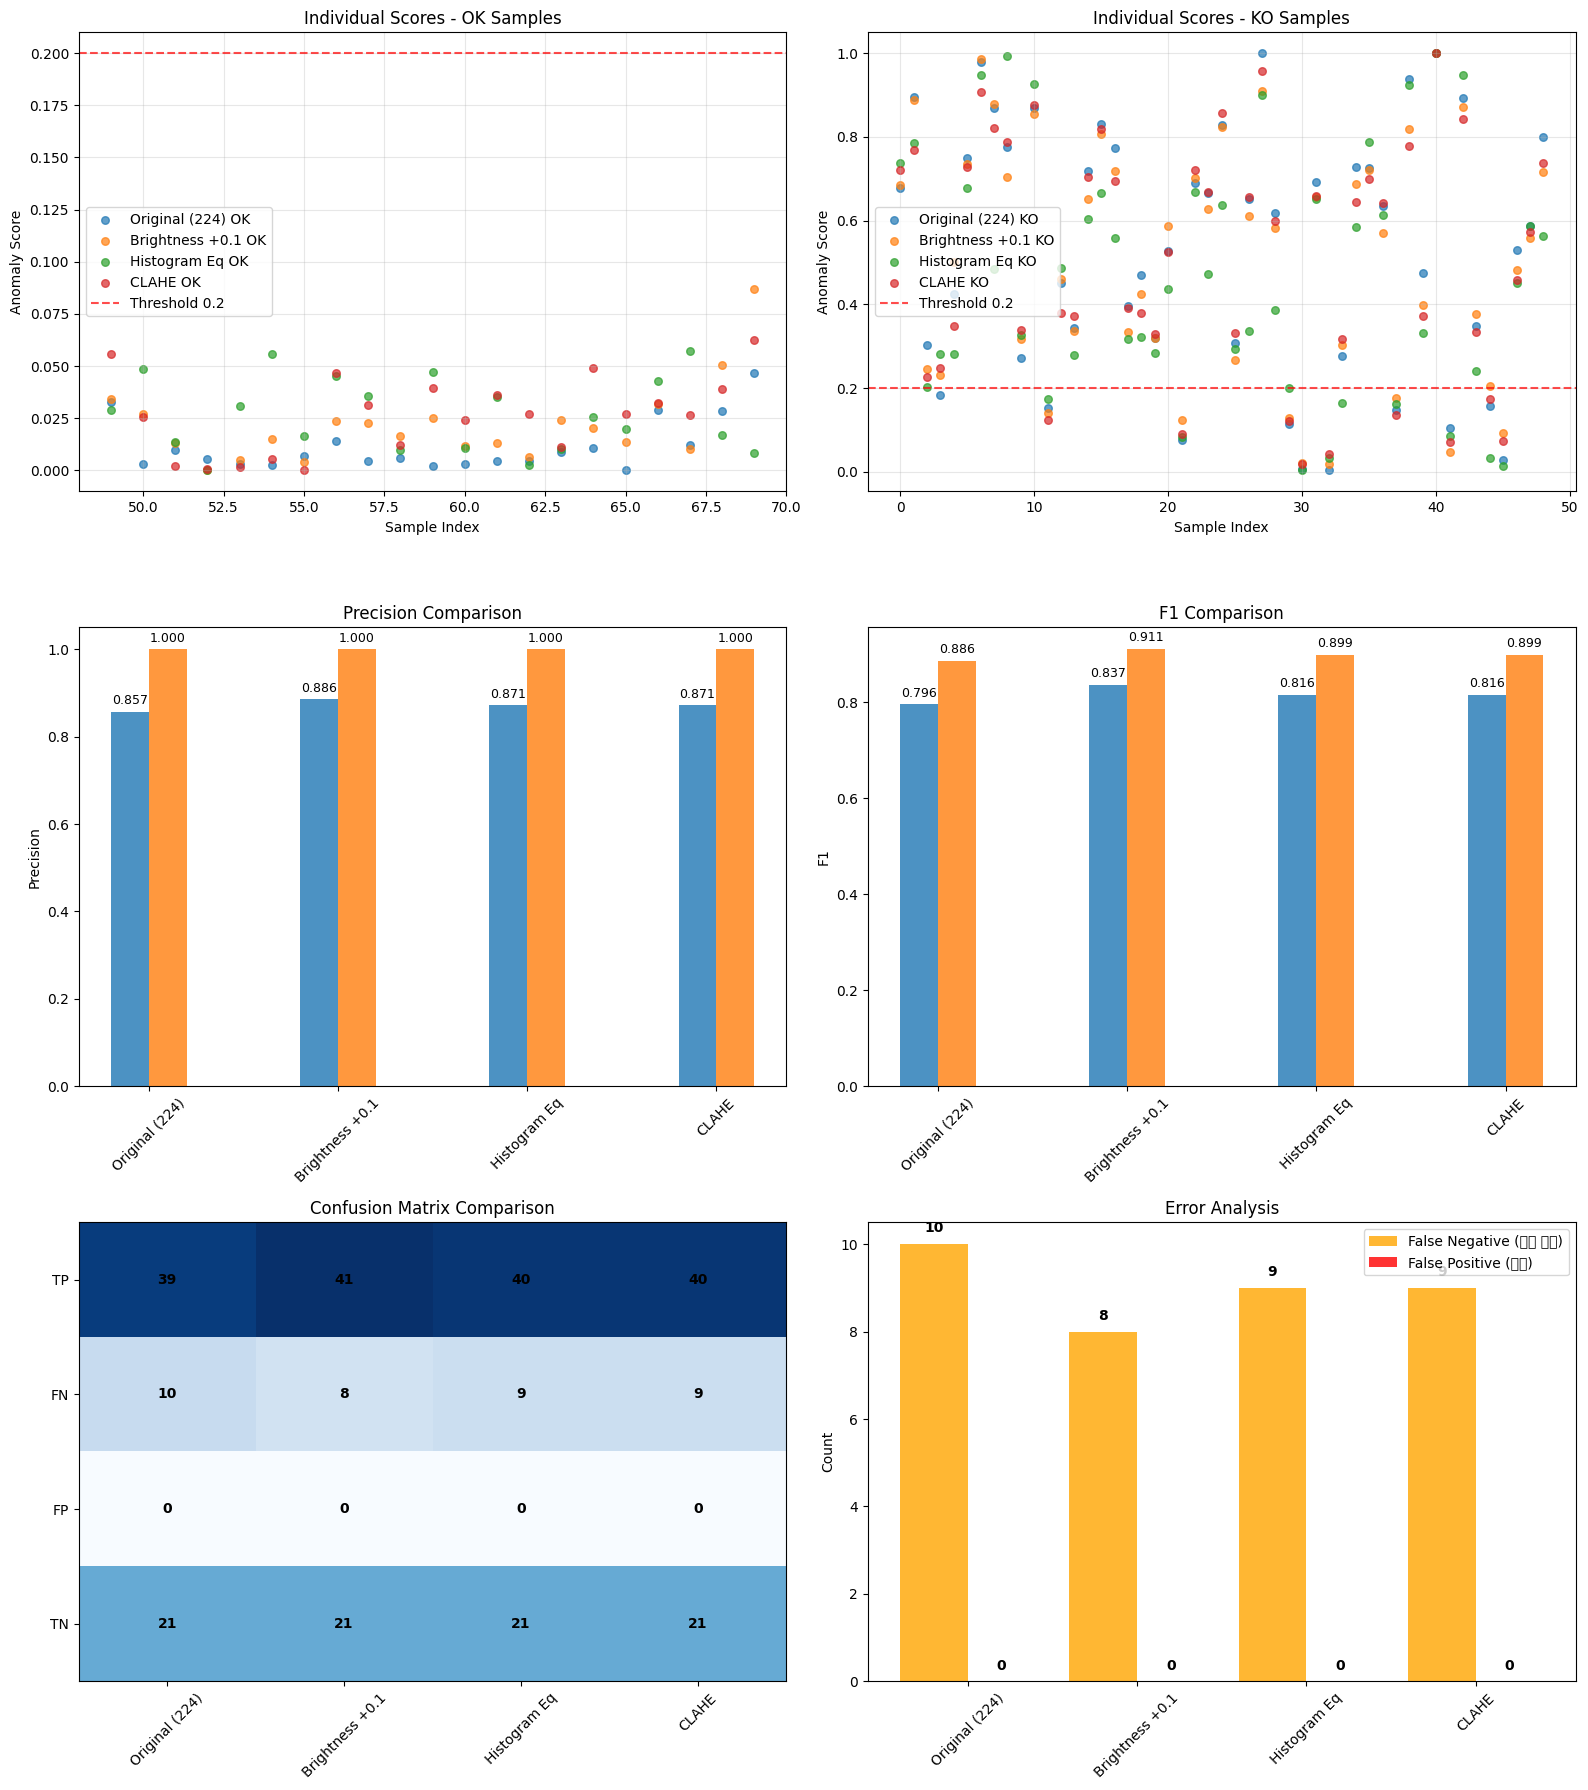


최고 성능 전처리:
--------------------------------------------------
Accuracy  : Brightness +0.1 (0.8857)
Precision : Original (224) (1.0000)
Recall    : Brightness +0.1 (0.8367)
F1        : Brightness +0.1 (0.9111)

종합 최고: Brightness +0.1 (Accuracy + F1 = 1.7968)

Original (224) 대비 개선:
----------------------------------------
Brightness +0.1:
  정확도: +0.0286
  FN 변화: -2 (이상 놓침)
  FP 변화: +0 (오탐)
Histogram Eq:
  정확도: +0.0143
  FN 변화: -1 (이상 놓침)
  FP 변화: +0 (오탐)
CLAHE:
  정확도: +0.0143
  FN 변화: -1 (이상 놓침)
  FP 변화: +0 (오탐)


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def load_all_experiments_scores(results_base_path):
    experiments = {
        'Original (224)': ('BTAD01_224_WR50_L2-3', 'btad_01'),
        'Brightness +0.1': ('BTAD_brightness_224_WR50_L2-3', 'btad_03_brightness'), 
        'Histogram Eq': ('BTAD_histogram_224_WR50_L2-3', 'btad_04_histogram_eq'),
        'CLAHE': ('BTAD_clahe_224_WR50_L2-3', 'btad_05_clahe')
    }
    
    all_data = {}
    
    for exp_name, (folder_name, subfolder) in experiments.items():
        scores_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/scores.npy")
        folder_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/")
        
        print(f"확인 중: {scores_path}")
        
        if os.path.exists(scores_path) and os.path.exists(folder_path):
            scores = np.load(scores_path)
            files = sorted(os.listdir(folder_path))
            png_files = [f for f in files if f.endswith('.png')]
            
            labels = []
            image_names = []
            for file in png_files:
                if "_OK_" in file:
                    labels.append(0)
                elif "_KO_" in file:
                    labels.append(1)
                # 파일명에서 이미지 이름 추출
                parts = file.split('_')
                if len(parts) >= 4:
                    image_names.append(f"{parts[1]}_{parts[2]}_{parts[3]}")
                else:
                    image_names.append(file.replace('.png', ''))
            
            if len(scores) == len(labels):
                all_data[exp_name] = {
                    'scores': scores, 
                    'labels': np.array(labels),
                    'image_names': image_names
                }
                print(f"✅ {exp_name}: {len(scores)}개 점수 로드")
            else:
                print(f"❌ {exp_name}: 점수({len(scores)})와 레이블({len(labels)}) 개수 불일치")
        else:
            print(f"❌ {exp_name}: 파일 없음")
    
    return all_data

def create_individual_comparison_plots(all_data, threshold=0.2):
    
    # 모든 실험의 성능 비교
    performance_summary = {}
    
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        
        predictions = (scores >= threshold).astype(int)
        tp = np.sum((predictions == 1) & (labels == 1))
        tn = np.sum((predictions == 0) & (labels == 0))
        fp = np.sum((predictions == 1) & (labels == 0))
        fn = np.sum((predictions == 0) & (labels == 1))
        
        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        performance_summary[exp_name] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        }
    
    # 성능 비교 테이블
    perf_df = pd.DataFrame(performance_summary).T
    perf_df = perf_df.round(4)
    
    print(f"\n모든 전처리 Threshold {threshold}에서의 성능 비교:")
    print("-" * 80)
    print(perf_df[['accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn']])
    
    # 시각화
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. 개별 점수 비교 (첫 번째 실험 기준으로 정렬)
    first_exp = list(all_data.keys())[0]
    sample_indices = np.arange(len(all_data[first_exp]['scores']))
    
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        
        # OK와 KO 구분해서 플롯
        ok_indices = sample_indices[labels == 0]
        ko_indices = sample_indices[labels == 1]
        
        axes[0,0].scatter(ok_indices, scores[labels == 0], alpha=0.7, 
                         label=f'{exp_name} OK', s=30)
        axes[0,1].scatter(ko_indices, scores[labels == 1], alpha=0.7, 
                         label=f'{exp_name} KO', s=30)
    
    axes[0,0].axhline(y=threshold, color='red', linestyle='--', alpha=0.7, label=f'Threshold {threshold}')
    axes[0,1].axhline(y=threshold, color='red', linestyle='--', alpha=0.7, label=f'Threshold {threshold}')
    axes[0,0].set_title('Individual Scores - OK Samples')
    axes[0,1].set_title('Individual Scores - KO Samples')
    axes[0,0].set_xlabel('Sample Index')
    axes[0,1].set_xlabel('Sample Index')
    axes[0,0].set_ylabel('Anomaly Score')
    axes[0,1].set_ylabel('Anomaly Score')
    axes[0,0].legend()
    axes[0,1].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,1].grid(True, alpha=0.3)
    
    # 2. 성능 지표 비교
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    x_pos = np.arange(len(all_data))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        values = [performance_summary[exp][metric] for exp in all_data.keys()]
        axes[1, i//2].bar(x_pos + (i%2)*width, values, width, 
                         label=metric.capitalize(), alpha=0.8)
        
        if i < 2:
            axes[1, i//2].set_title(f'{metric.capitalize()} Comparison')
        else:
            axes[1, i//2].set_title(f'{metric.capitalize()} Comparison')
        
        axes[1, i//2].set_xticks(x_pos + width/2)
        axes[1, i//2].set_xticklabels(list(all_data.keys()), rotation=45)
        axes[1, i//2].set_ylabel(metric.capitalize())
        
        # 값 표시
        for j, v in enumerate(values):
            axes[1, i//2].text(j + (i%2)*width, v + 0.01, f'{v:.3f}', 
                              ha='center', va='bottom', fontsize=9)
    
    # 3. 혼동 행렬 비교
    confusion_data = []
    for exp_name in all_data.keys():
        perf = performance_summary[exp_name]
        confusion_data.append([perf['tp'], perf['fn'], perf['fp'], perf['tn']])
    
    confusion_array = np.array(confusion_data)
    im = axes[2,0].imshow(confusion_array.T, cmap='Blues', aspect='auto')
    axes[2,0].set_title('Confusion Matrix Comparison')
    axes[2,0].set_xticks(range(len(all_data)))
    axes[2,0].set_xticklabels(list(all_data.keys()), rotation=45)
    axes[2,0].set_yticks(range(4))
    axes[2,0].set_yticklabels(['TP', 'FN', 'FP', 'TN'])
    
    # 값 표시
    for i in range(len(all_data)):
        for j in range(4):
            axes[2,0].text(i, j, f'{confusion_array[i,j]:.0f}', 
                          ha='center', va='center', fontweight='bold')
    
    # 4. 오류 분석 (FN과 FP 비교)
    fn_counts = [performance_summary[exp]['fn'] for exp in all_data.keys()]
    fp_counts = [performance_summary[exp]['fp'] for exp in all_data.keys()]
    
    x_pos = np.arange(len(all_data))
    axes[2,1].bar(x_pos - 0.2, fn_counts, 0.4, label='False Negative (놓친 이상)', color='orange', alpha=0.8)
    axes[2,1].bar(x_pos + 0.2, fp_counts, 0.4, label='False Positive (오탐)', color='red', alpha=0.8)
    axes[2,1].set_title('Error Analysis')
    axes[2,1].set_xticks(x_pos)
    axes[2,1].set_xticklabels(list(all_data.keys()), rotation=45)
    axes[2,1].set_ylabel('Count')
    axes[2,1].legend()
    
    # 값 표시
    for i, (fn, fp) in enumerate(zip(fn_counts, fp_counts)):
        axes[2,1].text(i - 0.2, fn + 0.2, f'{fn}', ha='center', va='bottom', fontweight='bold')
        axes[2,1].text(i + 0.2, fp + 0.2, f'{fp}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return performance_summary

def find_best_preprocessing(performance_summary):
    print(f"\n최고 성능 전처리:")
    print("-" * 50)
    
    # 각 지표별 최고 성능
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metrics:
        best_exp = max(performance_summary.keys(), 
                      key=lambda x: performance_summary[x][metric])
        best_val = performance_summary[best_exp][metric]
        print(f"{metric.capitalize():10}: {best_exp} ({best_val:.4f})")
    
    # 종합 점수 계산 (accuracy + f1)
    combined_scores = {}
    for exp_name, perf in performance_summary.items():
        combined_scores[exp_name] = perf['accuracy'] + perf['f1']
    
    best_overall = max(combined_scores.keys(), key=lambda x: combined_scores[x])
    print(f"\n종합 최고: {best_overall} (Accuracy + F1 = {combined_scores[best_overall]:.4f})")
    
    # 원본 대비 개선 분석
    if 'Original (224)' in performance_summary:
        baseline = performance_summary['Original (224)']
        print(f"\nOriginal (224) 대비 개선:")
        print("-" * 40)
        
        for exp_name, perf in performance_summary.items():
            if exp_name != 'Original (224)':
                acc_change = perf['accuracy'] - baseline['accuracy']
                fn_change = perf['fn'] - baseline['fn']
                fp_change = perf['fp'] - baseline['fp']
                
                print(f"{exp_name}:")
                print(f"  정확도: {acc_change:+.4f}")
                print(f"  FN 변화: {fn_change:+.0f} (이상 놓침)")
                print(f"  FP 변화: {fp_change:+.0f} (오탐)")

# 실행
results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"
all_data = load_all_experiments_scores(results_base_path)

if all_data:
    performance_summary = create_individual_comparison_plots(all_data, threshold=0.2)
    find_best_preprocessing(performance_summary)
else:
    print("데이터를 찾을 수 없습니다.")

In [75]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from pathlib import Path
from tqdm import tqdm

def apply_brightness(image, brightness=0.1):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(1.0 + brightness)

def apply_histogram_equalization(image):
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    lab[:,:,0] = cv2.equalizeHist(lab[:,:,0])
    img_eq = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_eq = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_eq)

def apply_clahe(image, clip_limit=2.0):
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_clahe)

def apply_combo_preprocessing(image, combo_type):
    """조합 전처리 적용"""
    if combo_type == "brightness_clahe":
        img = apply_brightness(image, 0.1)
        img = apply_clahe(img, 2.0)
    elif combo_type == "brightness_histogram":
        img = apply_brightness(image, 0.1) 
        img = apply_histogram_equalization(img)
    elif combo_type == "all_combo":
        img = apply_brightness(image, 0.1)
        img = apply_histogram_equalization(img)
        img = apply_clahe(img, 2.0)
    return img

def create_combo_dataset(source_path, target_path, combo_type):
    """조합 전처리 데이터셋 생성"""
    
    source_root = Path(source_path)
    target_root = Path(target_path)
    
    target_root.mkdir(parents=True, exist_ok=True)
    
    splits = ["train", "test"]
    total_files = 0
    processed_files = 0
    
    # 전체 파일 수 계산
    for split in splits:
        split_path = source_root / split
        if split_path.exists():
            for class_dir in split_path.iterdir():
                if class_dir.is_dir():
                    image_files = list(class_dir.glob("*.bmp")) + list(class_dir.glob("*.png"))
                    total_files += len(image_files)
    
    print(f"총 {total_files}개 파일 처리 시작 ({combo_type})...")
    
    # 각 split 처리
    for split in splits:
        split_path = source_root / split
        if not split_path.exists():
            continue
            
        target_split_path = target_root / split
        target_split_path.mkdir(exist_ok=True)
        
        # 각 클래스 폴더 처리
        for class_dir in split_path.iterdir():
            if not class_dir.is_dir():
                continue
                
            class_name = class_dir.name
            target_class_path = target_split_path / class_name
            target_class_path.mkdir(exist_ok=True)
            
            # 이미지 파일들 처리
            image_files = list(class_dir.glob("*.bmp")) + list(class_dir.glob("*.png"))
            
            for img_file in tqdm(image_files, desc=f"Processing {split}/{class_name}"):
                try:
                    # 이미지 로드
                    image = Image.open(img_file).convert("RGB")
                    
                    # 조합 전처리 적용
                    processed_image = apply_combo_preprocessing(image, combo_type)
                    
                    # 저장
                    target_file = target_class_path / img_file.name
                    processed_image.save(target_file)
                    
                    processed_files += 1
                    
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
    
    print(f"완료! {processed_files}/{total_files} 파일 처리됨")

def create_all_combo_datasets(base_source_path, base_target_path):
    """모든 조합 전처리 데이터셋 생성"""
    
    combo_configs = {
        "06_brightness_clahe": "brightness_clahe",
        "07_brightness_histogram": "brightness_histogram", 
        "08_all_combo": "all_combo"
    }
    
    for folder_name, combo_type in combo_configs.items():
        print(f"\n{'='*60}")
        print(f"Creating {folder_name} with {combo_type} preprocessing...")
        print(f"{'='*60}")
        
        target_path = os.path.join(base_target_path, folder_name)
        create_combo_dataset(base_source_path, target_path, combo_type)

# 실행
base_source = "/mnt/d/BTech_Dataset_transformed/01"
base_target = "/mnt/d/BTech_Dataset_transformed"

print("조합 전처리 데이터셋 생성 시작...")
create_all_combo_datasets(base_source, base_target)

print("\n모든 조합 전처리 완료!")
print("생성된 폴더들:")
print("- 06_brightness_clahe: 밝기 + CLAHE")
print("- 07_brightness_histogram: 밝기 + 히스토그램 평활화")  
print("- 08_all_combo: 밝기 + 히스토그램 + CLAHE")

# PatchCore 실행 명령어들
print("\n실행할 PatchCore 명령어들:")
print()

commands = [
    ("06_brightness_clahe", "BTAD_brightness_clahe_224"),
    ("07_brightness_histogram", "BTAD_brightness_histogram_224"), 
    ("08_all_combo", "BTAD_all_combo_224")
]

for folder, log_name in commands:
    print(f"# {folder}")
    print(f"python bin/run_patchcore.py --gpu 0 --seed 0 --save_segmentation_images \\")
    print(f"  --log_group {log_name} results \\")
    print(f"  patch_core -b wideresnet50 -le layer2 -le layer3 \\")
    print(f"  --pretrain_embed_dimension 1024 --target_embed_dimension 1024 \\")
    print(f"  --anomaly_scorer_num_nn 1 --patchsize 3 \\")
    print(f"  sampler -p 0.01 approx_greedy_coreset \\")
    print(f"  dataset --resize 256 --imagesize 224 -d {folder} btad /mnt/d/BTech_Dataset_transformed")
    print()

조합 전처리 데이터셋 생성 시작...

Creating 06_brightness_clahe with brightness_clahe preprocessing...
총 470개 파일 처리 시작 (brightness_clahe)...


Processing test/ok: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]


완료! 470/470 파일 처리됨

Creating 07_brightness_histogram with brightness_histogram preprocessing...
총 470개 파일 처리 시작 (brightness_histogram)...


Processing test/ok: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]


완료! 470/470 파일 처리됨

Creating 08_all_combo with all_combo preprocessing...
총 470개 파일 처리 시작 (all_combo)...


Processing test/ok: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]

완료! 470/470 파일 처리됨

모든 조합 전처리 완료!
생성된 폴더들:
- 06_brightness_clahe: 밝기 + CLAHE
- 07_brightness_histogram: 밝기 + 히스토그램 평활화
- 08_all_combo: 밝기 + 히스토그램 + CLAHE

실행할 PatchCore 명령어들:

# 06_brightness_clahe
python bin/run_patchcore.py --gpu 0 --seed 0 --save_segmentation_images \
  --log_group BTAD_brightness_clahe_224 results \
  patch_core -b wideresnet50 -le layer2 -le layer3 \
  --pretrain_embed_dimension 1024 --target_embed_dimension 1024 \
  --anomaly_scorer_num_nn 1 --patchsize 3 \
  sampler -p 0.01 approx_greedy_coreset \
  dataset --resize 256 --imagesize 224 -d 06_brightness_clahe btad /mnt/d/BTech_Dataset_transformed

# 07_brightness_histogram
python bin/run_patchcore.py --gpu 0 --seed 0 --save_segmentation_images \
  --log_group BTAD_brightness_histogram_224 results \
  patch_core -b wideresnet50 -le layer2 -le layer3 \
  --pretrain_embed_dimension 1024 --target_embed_dimension 1024 \
  --anomaly_scorer_num_nn 1 --patchsize 3 \
  sampler -p 0.01 approx_greedy_coreset \
  dataset --r

조합 전처리 포함 모든 실험 결과 분석...
✅ Original (224): 70개 점수 로드
✅ Brightness +0.1: 70개 점수 로드
✅ Histogram Eq: 70개 점수 로드
✅ CLAHE: 70개 점수 로드
✅ Brightness + Histogram: 70개 점수 로드
✅ Brightness + CLAHE: 70개 점수 로드
✅ All Combo: 70개 점수 로드

Threshold 0.1에서의 성능 비교

Threshold 0.15에서의 성능 비교

Threshold 0.2에서의 성능 비교

상세 성능 비교 테이블

📊 Threshold 0.1 상세 결과:
----------------------------------------------------------------------
                       accuracy precision  recall      f1  tp  tn  fp  fn
Original (224)           0.9429    1.0000  0.9184  0.9574  45  21   0   4
Brightness +0.1          0.9429    1.0000  0.9184  0.9574  45  21   0   4
Histogram Eq             0.9143    1.0000  0.8776  0.9348  43  21   0   6
CLAHE                    0.9286    1.0000  0.8980  0.9462  44  21   0   5
Brightness + Histogram   0.9143    1.0000  0.8776  0.9348  43  21   0   6
Brightness + CLAHE       0.9143    1.0000  0.8776  0.9348  43  21   0   6
All Combo                0.9143    1.0000  0.8776  0.9348  43  21   0   6

🏆 성능 순위

/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/1270236638.py:216: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  plt.tight_layout()
/home/lkmsdf159/miniconda3/envs/patchcore/

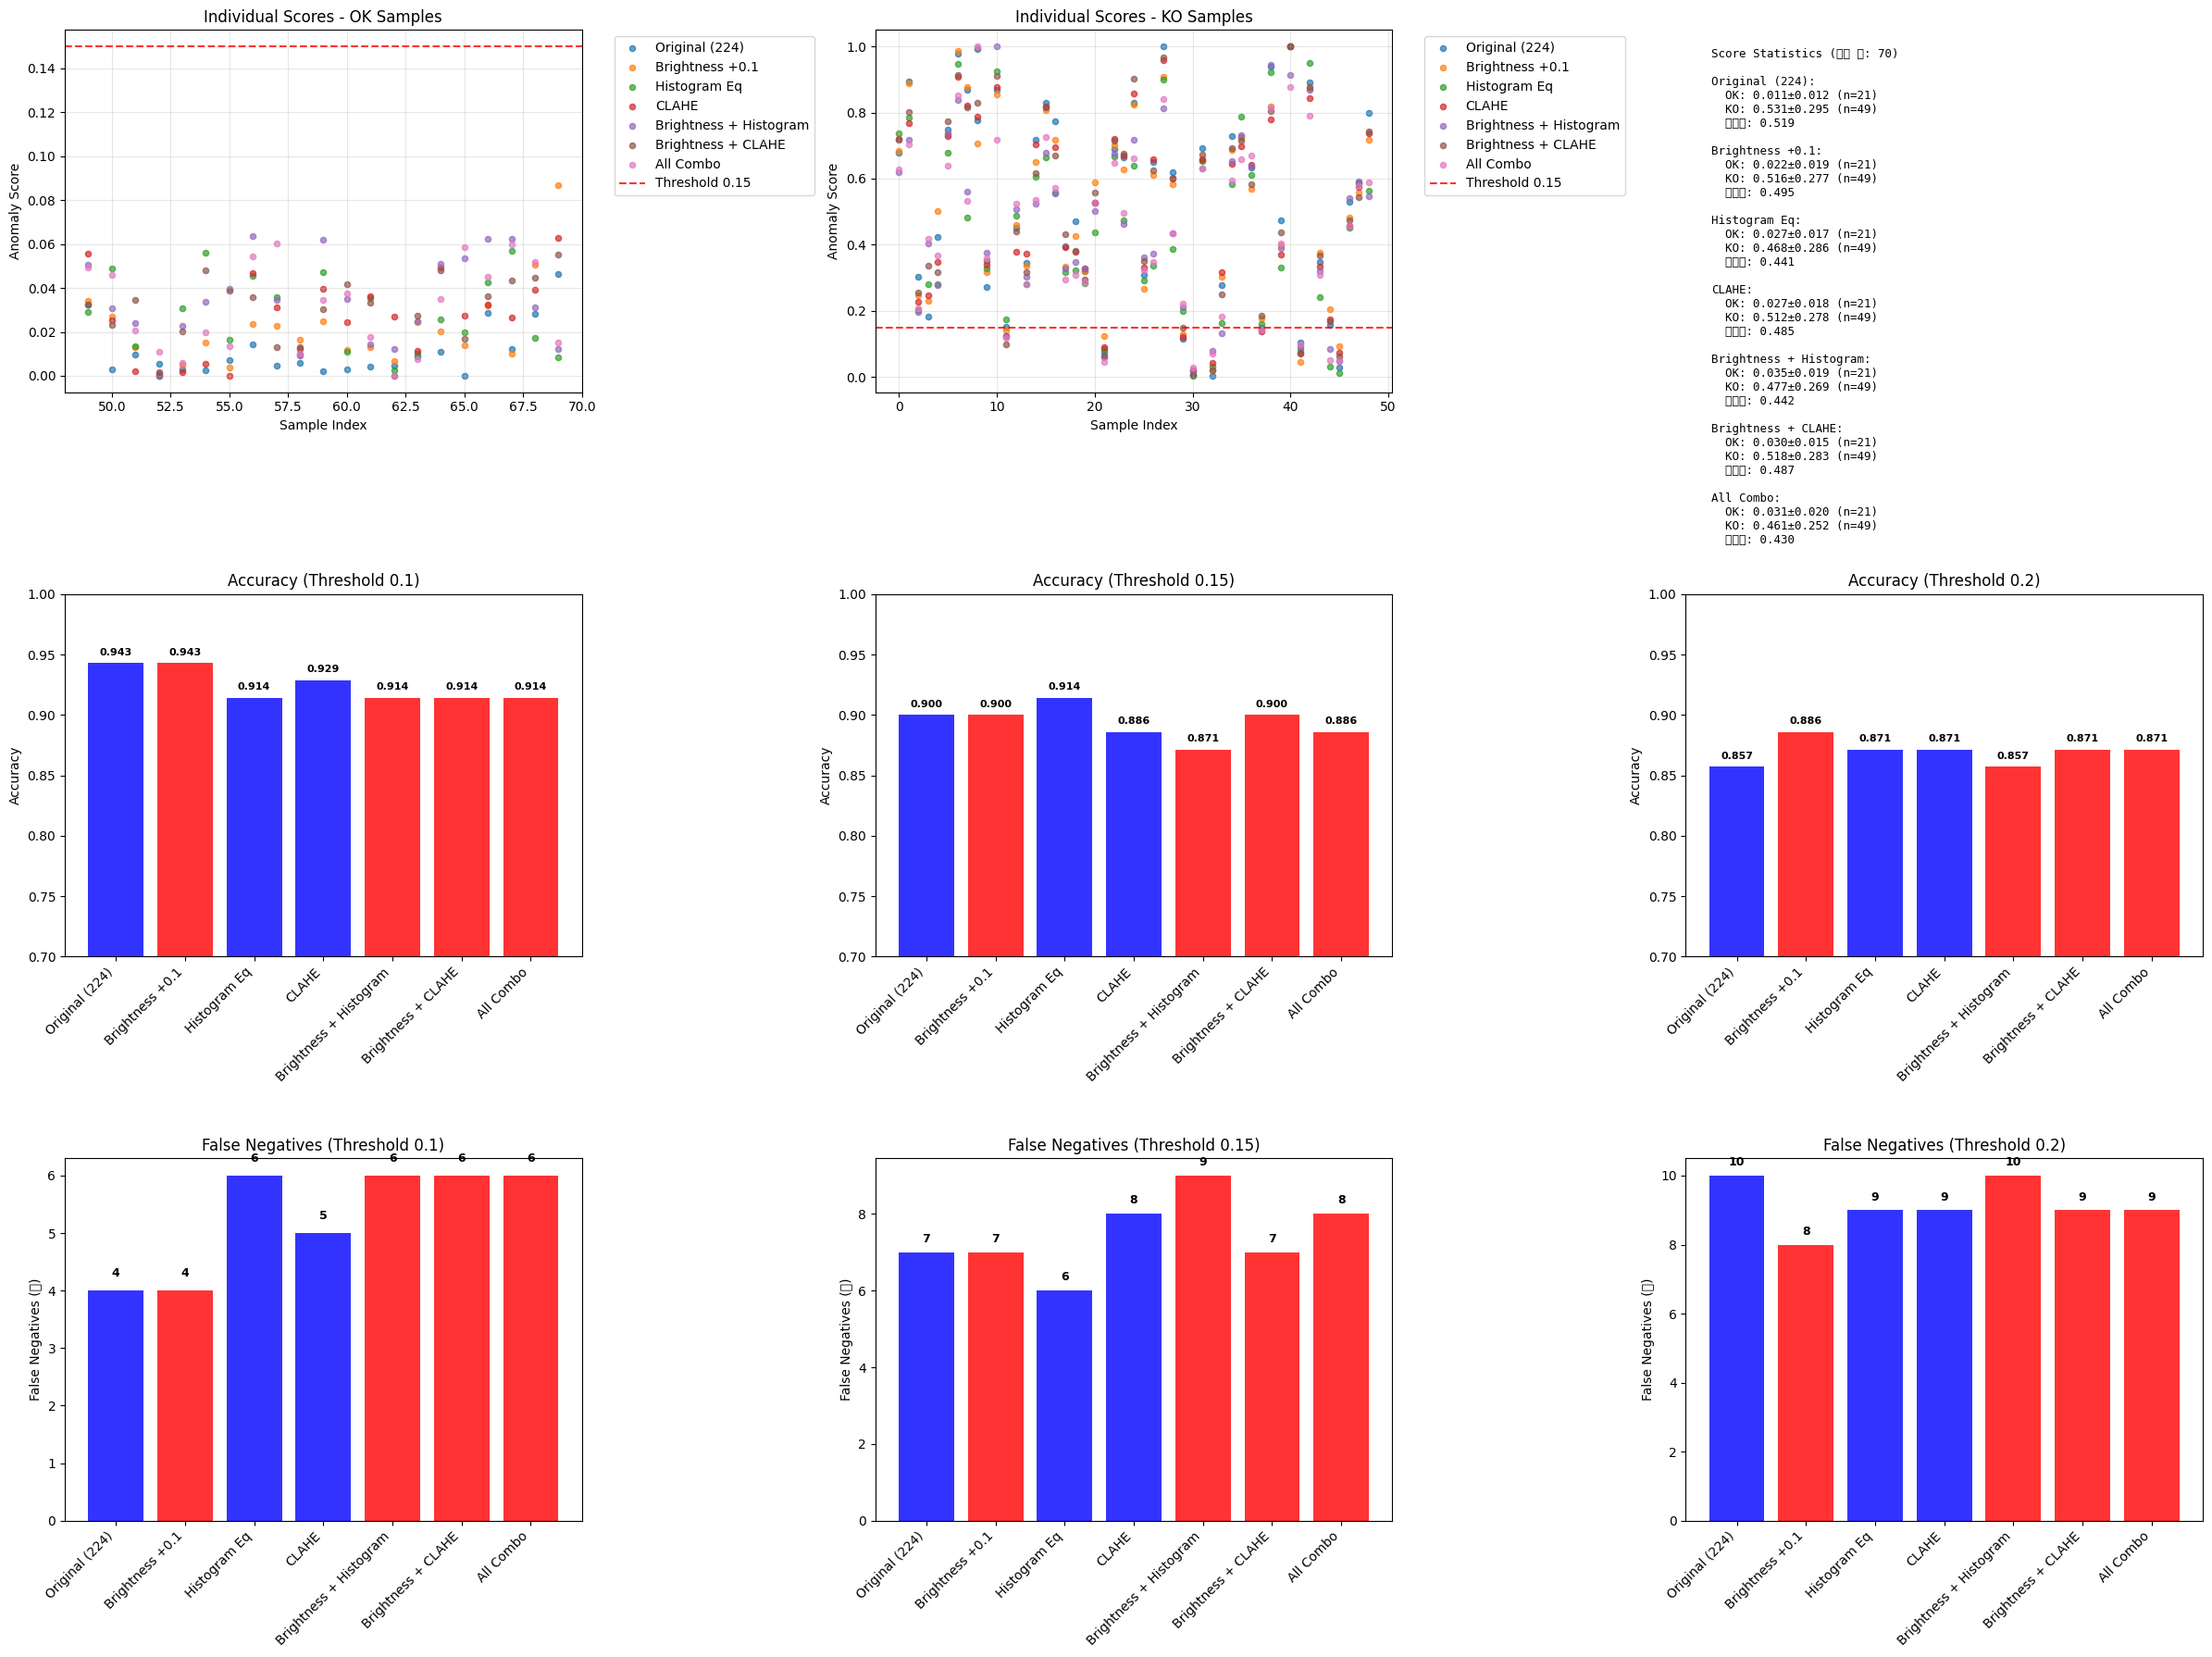


개별 샘플 개선 분석 (Threshold 0.15)
Original (224) 오분류 분석:
  총 FN (놓친 이상): 7개 - indices: [21 29 30 32 37 41 45]
  총 FP (오탐): 0개 - indices: []

Brightness +0.1:
  현재 FN: 7개, FP: 0개
  개선된 FN: 1개 - indices: [37]
  새로운 FP: 0개 - indices: []
  순 개선: FN +0개, FP +0개

Histogram Eq:
  현재 FN: 6개, FP: 0개
  개선된 FN: 2개 - indices: [29, 37]
  새로운 FP: 0개 - indices: []
  순 개선: FN +1개, FP +0개

CLAHE:
  현재 FN: 8개, FP: 0개
  개선된 FN: 0개 - indices: []
  새로운 FP: 0개 - indices: []
  순 개선: FN -1개, FP +0개

Brightness + Histogram:
  현재 FN: 9개, FP: 0개
  개선된 FN: 1개 - indices: [29]
  새로운 FP: 0개 - indices: []
  순 개선: FN -2개, FP +0개

Brightness + CLAHE:
  현재 FN: 7개, FP: 0개
  개선된 FN: 1개 - indices: [37]
  새로운 FP: 0개 - indices: []
  순 개선: FN +0개, FP +0개

All Combo:
  현재 FN: 8개, FP: 0개
  개선된 FN: 1개 - indices: [29]
  새로운 FP: 0개 - indices: []
  순 개선: FN -1개, FP +0개

최종 종합 분석

Threshold 0.1 요약:
  최고 F1: Original (224) (0.9574)
  최소 FN: Original (224) (4개)
  최고 Recall: Original (224) (0.9184)

Threshold 0.15 요약:
  최고 F1: Histogram Eq

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def load_combo_experiments_scores(results_base_path):
    """조합 전처리 포함한 모든 실험 데이터 로드"""
    
    experiments = {
        'Original (224)': ('BTAD01_224_WR50_L2-3', 'btad_01'),
        'Brightness +0.1': ('BTAD_brightness_224_WR50_L2-3', 'btad_03_brightness'), 
        'Histogram Eq': ('BTAD_histogram_224_WR50_L2-3', 'btad_04_histogram_eq'),
        'CLAHE': ('BTAD_clahe_224_WR50_L2-3', 'btad_05_clahe'),
        'Brightness + Histogram': ('BTAD_brightness_histogram_224_WR50_L2-3', 'btad_07_brightness_histogram'),
        'Brightness + CLAHE': ('BTAD_brightness_clahe_224_WR50_L2-3', 'btad_06_brightness_clahe'),
        'All Combo': ('BTAD_all_combo_224_WR50_L2-3', 'btad_08_all_combo')
    }
    
    all_data = {}
    
    for exp_name, (folder_name, subfolder) in experiments.items():
        scores_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/scores.npy")
        
        if os.path.exists(scores_path):
            try:
                scores = np.load(scores_path)
                folder_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/")
                
                if os.path.exists(folder_path):
                    files = sorted(os.listdir(folder_path))
                    png_files = [f for f in files if f.endswith('.png')]
                    
                    labels = []
                    for file in png_files:
                        if "_OK_" in file:
                            labels.append(0)
                        elif "_KO_" in file:
                            labels.append(1)
                    
                    if len(scores) == len(labels):
                        all_data[exp_name] = {
                            'scores': scores, 
                            'labels': np.array(labels)
                        }
                        print(f"✅ {exp_name}: {len(scores)}개 점수 로드")
                    else:
                        print(f"❌ {exp_name}: 점수({len(scores)})와 레이블({len(labels)}) 불일치")
                        
            except Exception as e:
                print(f"❌ {exp_name}: 로드 실패 - {e}")
        else:
            print(f"❌ {exp_name}: 파일 없음 - {scores_path}")
    
    return all_data

def analyze_all_thresholds(all_data, thresholds=[0.1, 0.15, 0.2]):
    """여러 threshold에서 성능 분석"""
    
    results_by_threshold = {}
    
    for threshold in thresholds:
        print(f"\n{'='*60}")
        print(f"Threshold {threshold}에서의 성능 비교")
        print(f"{'='*60}")
        
        performance_summary = {}
        
        for exp_name, data in all_data.items():
            scores = data['scores']
            labels = data['labels']
            
            predictions = (scores >= threshold).astype(int)
            tp = np.sum((predictions == 1) & (labels == 1))
            tn = np.sum((predictions == 0) & (labels == 0))
            fp = np.sum((predictions == 1) & (labels == 0))
            fn = np.sum((predictions == 0) & (labels == 1))
            
            accuracy = (tp + tn) / len(labels)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            performance_summary[exp_name] = {
                'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
                'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
            }
        
        # DataFrame으로 변환 및 출력
        perf_df = pd.DataFrame(performance_summary).T
        perf_df = perf_df.round(4)
        
        print("\n성능 지표:")
        print("-" * 80)
        print(perf_df[['accuracy', 'precision', 'recall', 'f1']])
        
        print("\n혼동 행렬:")
        print("-" * 80)
        print(perf_df[['tp', 'tn', 'fp', 'fn']].astype(int))
        
        # 최고 성능 찾기
        print(f"\nThreshold {threshold} 최고 성능:")
        print("-" * 40)
        for metric in ['accuracy', 'f1', 'recall']:
            best_exp = perf_df[metric].idxmax()
            best_val = perf_df[metric].max()
            print(f"{metric.capitalize():10}: {best_exp} ({best_val:.4f})")
        
        # FN 기준 최고 성능 (가장 적게 놓침)
        min_fn_exp = perf_df['fn'].idxmin()
        min_fn_val = perf_df['fn'].min()
        print(f"{'최소 FN':10}: {min_fn_exp} ({int(min_fn_val)}개)")
        
        results_by_threshold[threshold] = perf_df
    
    return results_by_threshold

def create_comprehensive_comparison(results_by_threshold, all_data):
    """전체 비교 시각화 (individual scores 포함)"""
    
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    
    thresholds = list(results_by_threshold.keys())
    experiments = list(results_by_threshold[thresholds[0]].index)
    
    # 색상 설정 (조합 전처리 강조)
    colors = []
    for exp in experiments:
        if 'Combo' in exp or '+' in exp:
            colors.append('red')  # 조합 전처리는 빨간색
        elif 'Brightness' in exp:
            colors.append('orange')  # 밝기 전처리는 주황색
        else:
            colors.append('blue')  # 나머지는 파란색
    
    # 1. Individual Scores - OK Samples (threshold 0.15 기준)
    threshold_ref = 0.15
    sample_indices = np.arange(70)  # 총 70개 샘플
    
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        ok_indices = sample_indices[labels == 0]
        axes[0,0].scatter(ok_indices, scores[labels == 0], alpha=0.7, s=20, label=exp_name)
    
    axes[0,0].axhline(y=threshold_ref, color='red', linestyle='--', alpha=0.8, label=f'Threshold {threshold_ref}')
    axes[0,0].set_title('Individual Scores - OK Samples')
    axes[0,0].set_xlabel('Sample Index')
    axes[0,0].set_ylabel('Anomaly Score')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Individual Scores - KO Samples
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        ko_indices = sample_indices[labels == 1]
        axes[0,1].scatter(ko_indices, scores[labels == 1], alpha=0.7, s=20, label=exp_name)
    
    axes[0,1].axhline(y=threshold_ref, color='red', linestyle='--', alpha=0.8, label=f'Threshold {threshold_ref}')
    axes[0,1].set_title('Individual Scores - KO Samples')
    axes[0,1].set_xlabel('Sample Index')
    axes[0,1].set_ylabel('Anomaly Score')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Score Distribution Comparison
    axes[0,2].axis('off')
    stat_text = f"Score Statistics (샘플 수: {len(list(all_data.values())[0]['scores'])})\n\n"
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        ok_scores = scores[labels == 0]
        ko_scores = scores[labels == 1]
        
        stat_text += f"{exp_name}:\n"
        stat_text += f"  OK: {ok_scores.mean():.3f}±{ok_scores.std():.3f} (n={len(ok_scores)})\n"
        stat_text += f"  KO: {ko_scores.mean():.3f}±{ko_scores.std():.3f} (n={len(ko_scores)})\n"
        stat_text += f"  분리도: {ko_scores.mean() - ok_scores.mean():.3f}\n\n"
    
    axes[0,2].text(0.05, 0.95, stat_text, transform=axes[0,2].transAxes, 
                   fontsize=9, verticalalignment='top', fontfamily='monospace')
    
    # 4-6. Threshold별 Accuracy 비교
    for i, threshold in enumerate(thresholds):
        df = results_by_threshold[threshold]
        x_pos = np.arange(len(experiments))
        
        bars = axes[1, i].bar(x_pos, df['accuracy'], color=colors, alpha=0.8)
        axes[1, i].set_title(f'Accuracy (Threshold {threshold})')
        axes[1, i].set_xticks(x_pos)
        axes[1, i].set_xticklabels(experiments, rotation=45, ha='right')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].set_ylim(0.7, 1.0)
        
        # 값 표시
        for bar, val in zip(bars, df['accuracy']):
            axes[1, i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # 7-9. Threshold별 FN (놓친 이상) 비교
    for i, threshold in enumerate(thresholds):
        df = results_by_threshold[threshold]
        x_pos = np.arange(len(experiments))
        
        bars = axes[2, i].bar(x_pos, df['fn'], color=colors, alpha=0.8)
        axes[2, i].set_title(f'False Negatives (Threshold {threshold})')
        axes[2, i].set_xticks(x_pos)
        axes[2, i].set_xticklabels(experiments, rotation=45, ha='right')
        axes[2, i].set_ylabel('False Negatives (개)')
        
        # 값 표시
        for bar, val in zip(bars, df['fn']):
            axes[2, i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                           f'{int(val)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def create_detailed_performance_table(results_by_threshold):
    """상세 성능 테이블 생성"""
    
    print(f"\n{'='*80}")
    print("상세 성능 비교 테이블")
    print(f"{'='*80}")
    
    for threshold, df in results_by_threshold.items():
        print(f"\n📊 Threshold {threshold} 상세 결과:")
        print("-" * 70)
        
        # 성능 지표 테이블
        display_df = df[['accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn']].copy()
        display_df['accuracy'] = display_df['accuracy'].apply(lambda x: f"{x:.4f}")
        display_df['precision'] = display_df['precision'].apply(lambda x: f"{x:.4f}")
        display_df['recall'] = display_df['recall'].apply(lambda x: f"{x:.4f}")
        display_df['f1'] = display_df['f1'].apply(lambda x: f"{x:.4f}")
        display_df[['tp', 'tn', 'fp', 'fn']] = display_df[['tp', 'tn', 'fp', 'fn']].astype(int)
        
        print(display_df.to_string())
        
        # 순위 표시
        print(f"\n🏆 성능 순위:")
        print(f"  1. Accuracy 최고: {df['accuracy'].idxmax()} ({df['accuracy'].max():.4f})")
        print(f"  2. F1 Score 최고: {df['f1'].idxmax()} ({df['f1'].max():.4f})")
        print(f"  3. Recall 최고: {df['recall'].idxmax()} ({df['recall'].max():.4f})")
        print(f"  4. FN 최소: {df['fn'].idxmin()} ({int(df['fn'].min())}개)")

def analyze_individual_improvements(all_data, threshold=0.15):
    """개별 샘플 단위 개선 분석"""
    
    print(f"\n{'='*60}")
    print(f"개별 샘플 개선 분석 (Threshold {threshold})")
    print(f"{'='*60}")
    
    if 'Original (224)' not in all_data:
        print("Original 데이터가 없어 비교할 수 없습니다.")
        return
    
    baseline_scores = all_data['Original (224)']['scores']
    baseline_labels = all_data['Original (224)']['labels']
    baseline_preds = (baseline_scores >= threshold).astype(int)
    
    # 원본에서 틀린 샘플들 찾기
    baseline_errors = baseline_preds != baseline_labels
    baseline_fn_indices = np.where((baseline_preds == 0) & (baseline_labels == 1))[0]
    baseline_fp_indices = np.where((baseline_preds == 1) & (baseline_labels == 0))[0]
    
    print(f"Original (224) 오분류 분석:")
    print(f"  총 FN (놓친 이상): {len(baseline_fn_indices)}개 - indices: {baseline_fn_indices}")
    print(f"  총 FP (오탐): {len(baseline_fp_indices)}개 - indices: {baseline_fp_indices}")
    
    # 각 전처리별로 개선된 샘플 분석
    for exp_name, data in all_data.items():
        if exp_name == 'Original (224)':
            continue
            
        scores = data['scores']
        preds = (scores >= threshold).astype(int)
        
        # FN 개선 (원본에서 놓쳤는데 이제 잡은 것)
        improved_fn = []
        for idx in baseline_fn_indices:
            if preds[idx] == 1:  # 이제 올바르게 탐지
                improved_fn.append(idx)
        
        # FP 악화 (원본에서 맞았는데 이제 틀린 것)  
        new_fp = []
        current_fp_indices = np.where((preds == 1) & (baseline_labels == 0))[0]
        for idx in current_fp_indices:
            if idx not in baseline_fp_indices:  # 새로 생긴 FP
                new_fp.append(idx)
        
        current_fn = len(np.where((preds == 0) & (baseline_labels == 1))[0])
        current_fp = len(current_fp_indices)
        
        print(f"\n{exp_name}:")
        print(f"  현재 FN: {current_fn}개, FP: {current_fp}개")
        print(f"  개선된 FN: {len(improved_fn)}개 - indices: {improved_fn}")
        print(f"  새로운 FP: {len(new_fp)}개 - indices: {new_fp}")
        print(f"  순 개선: FN {len(baseline_fn_indices) - current_fn:+}개, FP {current_fp - len(baseline_fp_indices):+}개")

# 기존 함수들 수정 (create_comprehensive_comparison 호출 부분)
def analyze_all_thresholds(all_data, thresholds=[0.1, 0.15, 0.2]):
    """여러 threshold에서 성능 분석"""
    
    results_by_threshold = {}
    
    for threshold in thresholds:
        print(f"\n{'='*60}")
        print(f"Threshold {threshold}에서의 성능 비교")
        print(f"{'='*60}")
        
        performance_summary = {}
        
        for exp_name, data in all_data.items():
            scores = data['scores']
            labels = data['labels']
            
            predictions = (scores >= threshold).astype(int)
            tp = np.sum((predictions == 1) & (labels == 1))
            tn = np.sum((predictions == 0) & (labels == 0))
            fp = np.sum((predictions == 1) & (labels == 0))
            fn = np.sum((predictions == 0) & (labels == 1))
            
            accuracy = (tp + tn) / len(labels)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            performance_summary[exp_name] = {
                'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
                'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
            }
        
        results_by_threshold[threshold] = pd.DataFrame(performance_summary).T.round(4)
    
    return results_by_threshold

def find_ultimate_best(results_by_threshold):
    """최종 최고 성능 전처리 찾기"""
    
    print(f"\n{'='*60}")
    print("최종 종합 분석")
    print(f"{'='*60}")
    
    # 각 threshold에서 최고 성능들 수집
    best_performers = {}
    
    for threshold, df in results_by_threshold.items():
        print(f"\nThreshold {threshold} 요약:")
        print(f"  최고 F1: {df['f1'].idxmax()} ({df['f1'].max():.4f})")
        print(f"  최소 FN: {df['fn'].idxmin()} ({int(df['fn'].min())}개)")
        print(f"  최고 Recall: {df['recall'].idxmax()} ({df['recall'].max():.4f})")
        
        best_performers[threshold] = {
            'best_f1': (df['f1'].idxmax(), df['f1'].max()),
            'min_fn': (df['fn'].idxmin(), df['fn'].min()),
            'best_recall': (df['recall'].idxmax(), df['recall'].max())
        }
    
    # 조합 전처리의 효과 분석
    print(f"\n조합 전처리 효과:")
    print("-" * 40)
    
    single_preprocessings = ['Brightness +0.1', 'Histogram Eq', 'CLAHE']
    combo_preprocessings = ['Brightness + Histogram', 'Brightness + CLAHE', 'All Combo']
    
    for threshold, df in results_by_threshold.items():
        print(f"\nThreshold {threshold}:")
        
        if not df.empty:
            # 단일 전처리 중 최고
            available_single = [p for p in single_preprocessings if p in df.index]
            if available_single:
                best_single_fn = min(df.loc[available_single, 'fn'])
                best_single_name = df.loc[available_single, 'fn'].idxmin()
                
                # 조합 전처리 중 최고  
                available_combo = [p for p in combo_preprocessings if p in df.index]
                if available_combo:
                    best_combo_fn = min(df.loc[available_combo, 'fn'])
                    best_combo_name = df.loc[available_combo, 'fn'].idxmin()
                    
                    improvement = best_single_fn - best_combo_fn
                    print(f"  단일 최고: {best_single_name} (FN: {int(best_single_fn)})")
                    print(f"  조합 최고: {best_combo_name} (FN: {int(best_combo_fn)})")
                    print(f"  개선효과: {int(improvement)}개 추가 탐지")

# 실행
results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"

print("조합 전처리 포함 모든 실험 결과 분석...")
all_data = load_combo_experiments_scores(results_base_path)

if all_data:
    # 여러 threshold에서 분석
    results_by_threshold = analyze_all_thresholds(all_data, thresholds=[0.1, 0.15, 0.2])
    
    # 상세 성능 테이블 출력
    create_detailed_performance_table(results_by_threshold)
    
    # 시각화 (individual scores 포함)
    create_comprehensive_comparison(results_by_threshold, all_data)
    
    # 개별 샘플 개선 분석
    analyze_individual_improvements(all_data, threshold=0.15)
    
    # 최종 분석
    find_ultimate_best(results_by_threshold)
    
else:
    print("분석할 데이터가 없습니다.")

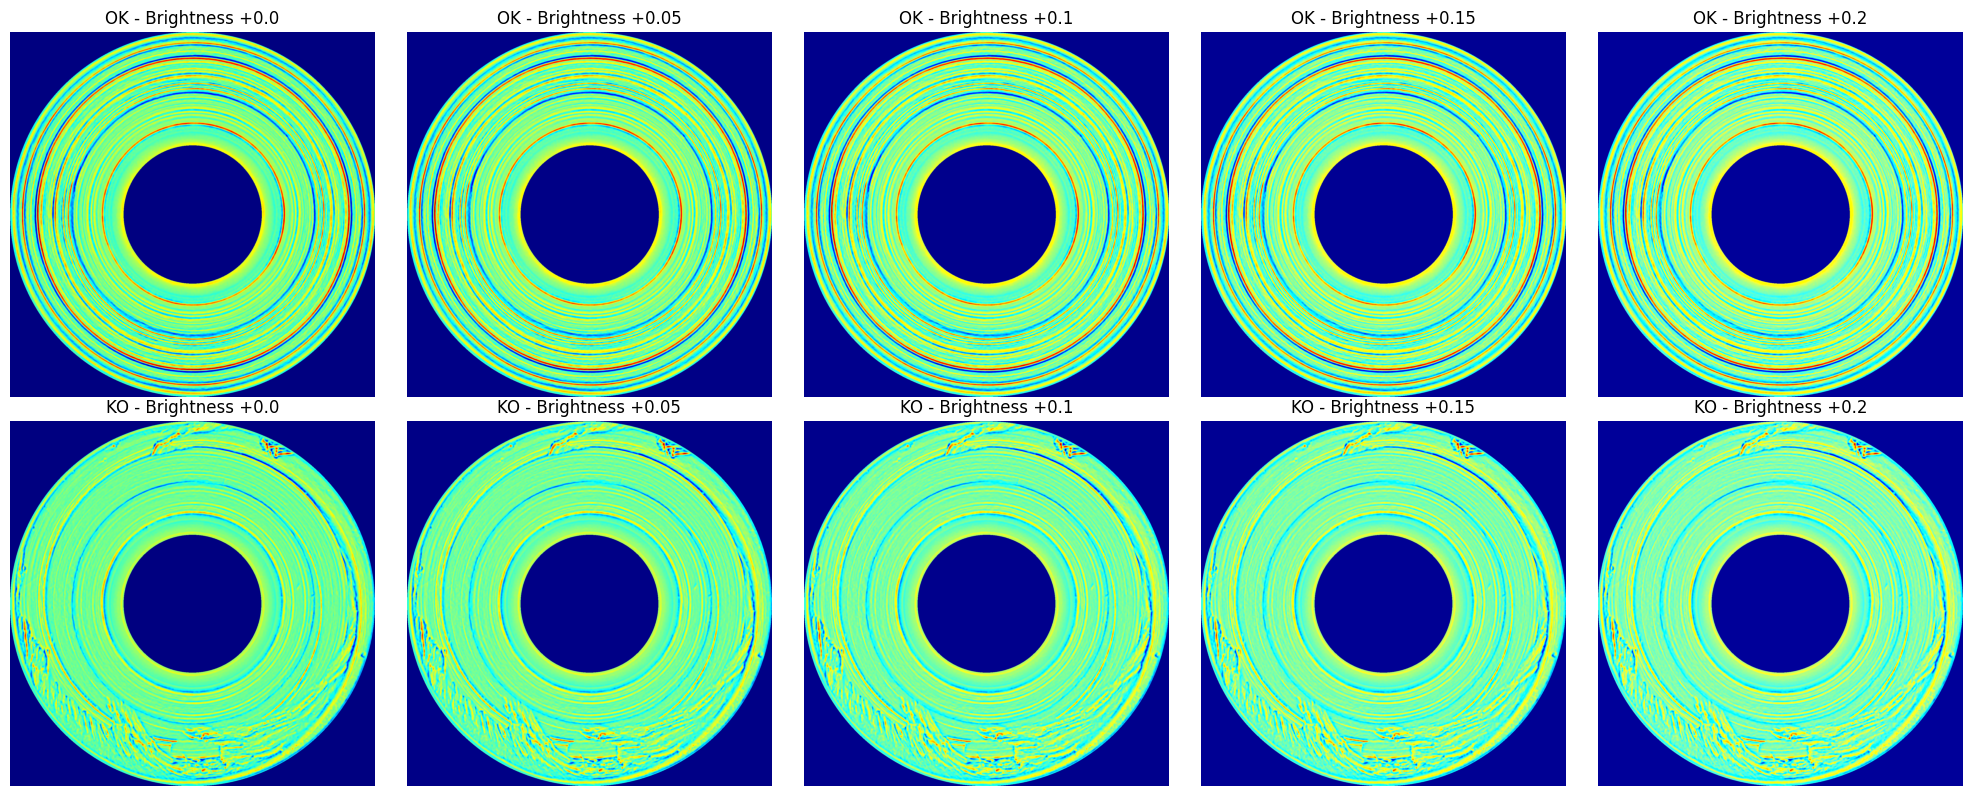

OK 이미지: 0000.bmp
KO 이미지: 0000.bmp
이미지 크기: (1600, 1600)


In [80]:
def apply_brightness(image, brightness):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(1.0 + brightness)

# 데이터 경로
data_path = "/mnt/d/BTech_Dataset_transformed/01/test"

# OK와 KO 샘플 하나씩 로드
ok_files = os.listdir(os.path.join(data_path, "ok"))
ko_files = os.listdir(os.path.join(data_path, "ko"))

ok_img = Image.open(os.path.join(data_path, "ok", ok_files[0])).convert("RGB")
ko_img = Image.open(os.path.join(data_path, "ko", ko_files[0])).convert("RGB")

# 밝기 레벨들
brightness_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

# 시각화
fig, axes = plt.subplots(2, len(brightness_levels), figsize=(20, 8))

for i, brightness in enumerate(brightness_levels):
    # OK 이미지
    ok_processed = apply_brightness(ok_img, brightness)
    axes[0, i].imshow(ok_processed)
    axes[0, i].set_title(f'OK - Brightness +{brightness}')
    axes[0, i].axis('off')
    
    # KO 이미지
    ko_processed = apply_brightness(ko_img, brightness)
    axes[1, i].imshow(ko_processed)
    axes[1, i].set_title(f'KO - Brightness +{brightness}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# 통계 정보
print(f"OK 이미지: {ok_files[0]}")
print(f"KO 이미지: {ko_files[0]}")
print(f"이미지 크기: {ok_img.size}")

밝기별 실험 결과 분석...
✅ Original (224): 70개 점수 로드
✅ Brightness +0.1: 70개 점수 로드
✅ Brightness +0.5: 70개 점수 로드
밝기별 최적 Threshold 성능 비교

Original (224) (Threshold 0.1):
  Accuracy: 0.9429
  F1 Score: 0.9574
  Recall: 0.9184
  FN: 4개, FP: 0개

Brightness +0.1 (Threshold 0.1):
  Accuracy: 0.9429
  F1 Score: 0.9574
  Recall: 0.9184
  FN: 4개, FP: 0개

Brightness +0.5 (Threshold 0.07):
  Accuracy: 0.9429
  F1 Score: 0.9583
  Recall: 0.9388
  FN: 3개, FP: 1개


/tmp/ipykernel_2797/2555754517.py:181: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2797/2555754517.py:181: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2797/2555754517.py:181: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.tight_layout()


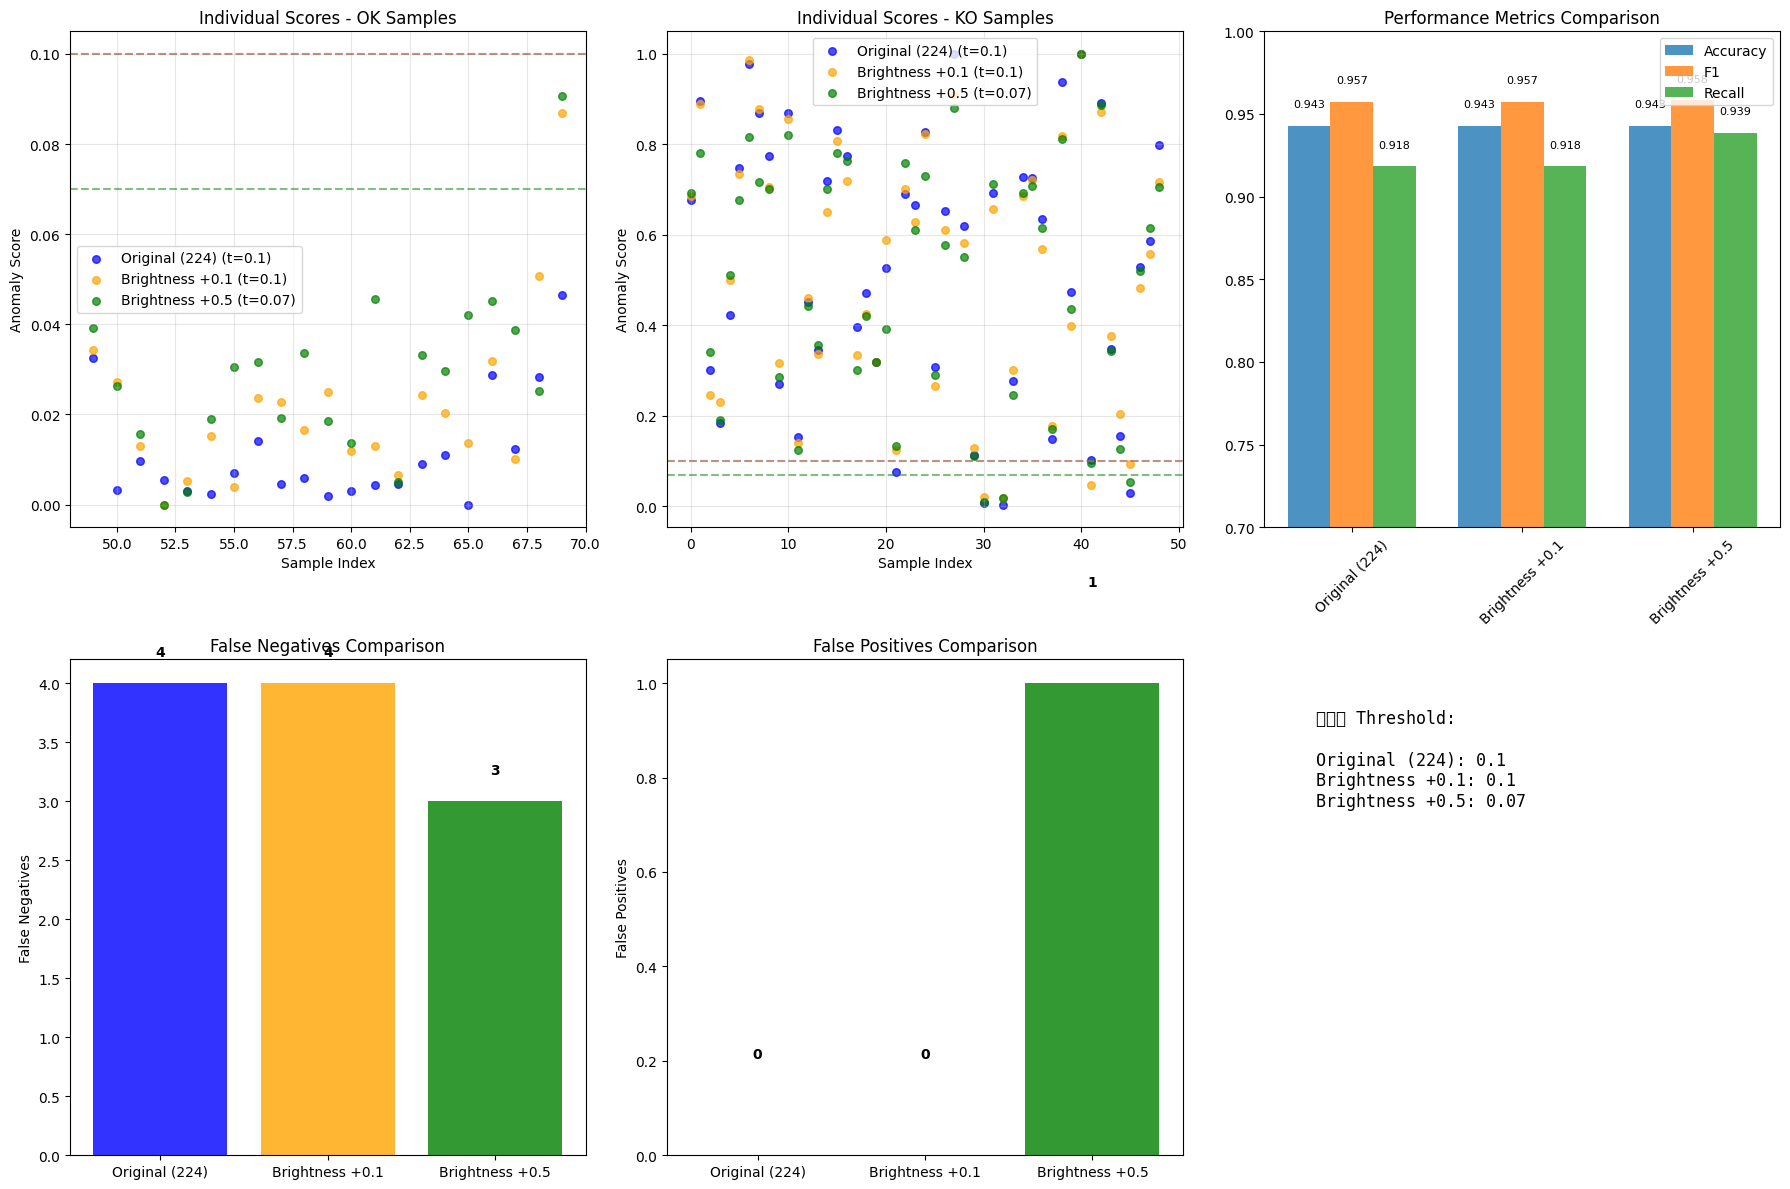


최종 성능 요약

🏆 최고 성능:
  Accuracy: Original (224) (0.9429)
  F1 Score: Brightness +0.5 (0.9583)
  최소 FN: Brightness +0.5 (3개)

📈 Original 대비 개선:

Brightness +0.1:
  FN 개선: +0개
  FP 변화: +0개
  정확도 개선: +0.0000

Brightness +0.5:
  FN 개선: +1개
  FP 변화: +1개
  정확도 개선: +0.0000


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def load_brightness_experiments(results_base_path):
    """밝기별 실험 데이터 로드"""
    
    experiments = {
        'Original (224)': ('BTAD01_224_WR50_L2-3', 'btad_01'),
        'Brightness +0.1': ('BTAD_brightness_224_WR50_L2-3', 'btad_03_brightness'), 
        'Brightness +0.5': ('BTAD_brightness_224_0.5_WR50_L2-3_0', 'btad_09_brightness_0.5')
    }
    
    all_data = {}
    
    for exp_name, (folder_name, subfolder) in experiments.items():
        scores_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/scores.npy")
        
        if os.path.exists(scores_path):
            scores = np.load(scores_path)
            folder_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/")
            
            if os.path.exists(folder_path):
                files = sorted(os.listdir(folder_path))
                png_files = [f for f in files if f.endswith('.png')]
                
                labels = []
                for file in png_files:
                    if "_OK_" in file:
                        labels.append(0)
                    elif "_KO_" in file:
                        labels.append(1)
                
                if len(scores) == len(labels):
                    all_data[exp_name] = {
                        'scores': scores, 
                        'labels': np.array(labels)
                    }
                    print(f"✅ {exp_name}: {len(scores)}개 점수 로드")
    
    return all_data

def test_thresholds(all_data):
    """각 실험별로 적절한 threshold에서 성능 테스트"""
    
    # 각 실험별 최적 threshold
    optimal_thresholds = {
        'Original (224)': 0.1,
        'Brightness +0.1': 0.1,
        'Brightness +0.5': 0.07
    }
    
    print("="*60)
    print("밝기별 최적 Threshold 성능 비교")
    print("="*60)
    
    results = {}
    
    for exp_name, data in all_data.items():
        threshold = optimal_thresholds.get(exp_name, 0.1)
        scores = data['scores']
        labels = data['labels']
        
        predictions = (scores >= threshold).astype(int)
        tp = np.sum((predictions == 1) & (labels == 1))
        tn = np.sum((predictions == 0) & (labels == 0))
        fp = np.sum((predictions == 1) & (labels == 0))
        fn = np.sum((predictions == 0) & (labels == 1))
        
        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results[exp_name] = {
            'threshold': threshold,
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        }
        
        print(f"\n{exp_name} (Threshold {threshold}):")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  FN: {fn}개, FP: {fp}개")
    
    return results

def create_comparison_plot(results, all_data):
    """성능 비교 시각화"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    exp_names = list(results.keys())
    colors = ['blue', 'orange', 'green']
    
    # 1. Individual Scores - OK Samples
    for i, (exp_name, data) in enumerate(all_data.items()):
        scores = data['scores']
        labels = data['labels']
        threshold = results[exp_name]['threshold']
        
        ok_indices = np.where(labels == 0)[0]
        axes[0,0].scatter(ok_indices, scores[labels == 0], alpha=0.7, s=30, 
                         label=f'{exp_name} (t={threshold})', color=colors[i])
        axes[0,0].axhline(y=threshold, color=colors[i], linestyle='--', alpha=0.5)
    
    axes[0,0].set_title('Individual Scores - OK Samples')
    axes[0,0].set_xlabel('Sample Index')
    axes[0,0].set_ylabel('Anomaly Score')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Individual Scores - KO Samples
    for i, (exp_name, data) in enumerate(all_data.items()):
        scores = data['scores']
        labels = data['labels']
        threshold = results[exp_name]['threshold']
        
        ko_indices = np.where(labels == 1)[0]
        axes[0,1].scatter(ko_indices, scores[labels == 1], alpha=0.7, s=30,
                         label=f'{exp_name} (t={threshold})', color=colors[i])
        axes[0,1].axhline(y=threshold, color=colors[i], linestyle='--', alpha=0.5)
    
    axes[0,1].set_title('Individual Scores - KO Samples')
    axes[0,1].set_xlabel('Sample Index')
    axes[0,1].set_ylabel('Anomaly Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 성능 지표 비교
    metrics = ['accuracy', 'f1', 'recall']
    x_pos = np.arange(len(exp_names))
    
    for i, metric in enumerate(metrics):
        values = [results[exp][metric] for exp in exp_names]
        bars = axes[0,2].bar(x_pos + i*0.25, values, 0.25, label=metric.capitalize(), alpha=0.8)
        
        # 값 표시
        for bar, val in zip(bars, values):
            axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    
    axes[0,2].set_title('Performance Metrics Comparison')
    axes[0,2].set_xticks(x_pos + 0.25)
    axes[0,2].set_xticklabels(exp_names, rotation=45)
    axes[0,2].legend()
    axes[0,2].set_ylim(0.7, 1.0)
    
    # 4. FN 비교
    fn_values = [results[exp]['fn'] for exp in exp_names]
    bars = axes[1,0].bar(exp_names, fn_values, color=colors, alpha=0.8)
    axes[1,0].set_title('False Negatives Comparison')
    axes[1,0].set_ylabel('False Negatives')
    
    for bar, val in zip(bars, fn_values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                      f'{int(val)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 5. FP 비교
    fp_values = [results[exp]['fp'] for exp in exp_names]
    bars = axes[1,1].bar(exp_names, fp_values, color=colors, alpha=0.8)
    axes[1,1].set_title('False Positives Comparison')
    axes[1,1].set_ylabel('False Positives')
    
    for bar, val in zip(bars, fp_values):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                      f'{int(val)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 6. Threshold 정보
    axes[1,2].axis('off')
    threshold_text = "사용된 Threshold:\n\n"
    for exp_name in exp_names:
        threshold = results[exp_name]['threshold']
        threshold_text += f"{exp_name}: {threshold}\n"
    
    axes[1,2].text(0.1, 0.9, threshold_text, transform=axes[1,2].transAxes, 
                   fontsize=12, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

def print_summary(results):
    """요약 결과 출력"""
    
    print("\n" + "="*60)
    print("최종 성능 요약")
    print("="*60)
    
    # 성능 순위
    best_accuracy = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_f1 = max(results.keys(), key=lambda x: results[x]['f1'])
    min_fn = min(results.keys(), key=lambda x: results[x]['fn'])
    
    print(f"\n🏆 최고 성능:")
    print(f"  Accuracy: {best_accuracy} ({results[best_accuracy]['accuracy']:.4f})")
    print(f"  F1 Score: {best_f1} ({results[best_f1]['f1']:.4f})")
    print(f"  최소 FN: {min_fn} ({int(results[min_fn]['fn'])}개)")
    
    # 원본 대비 개선
    if 'Original (224)' in results:
        baseline = results['Original (224)']
        print(f"\n📈 Original 대비 개선:")
        
        for exp_name, result in results.items():
            if exp_name != 'Original (224)':
                fn_improvement = baseline['fn'] - result['fn']
                fp_change = result['fp'] - baseline['fp']
                acc_improvement = result['accuracy'] - baseline['accuracy']
                
                print(f"\n{exp_name}:")
                print(f"  FN 개선: {fn_improvement:+}개")
                print(f"  FP 변화: {fp_change:+}개")
                print(f"  정확도 개선: {acc_improvement:+.4f}")

# 실행
results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"

print("밝기별 실험 결과 분석...")
all_data = load_brightness_experiments(results_base_path)

if all_data:
    # 최적 threshold에서 성능 테스트
    results = test_thresholds(all_data)
    
    # 시각화
    create_comparison_plot(results, all_data)
    
    # 요약
    print_summary(results)
    
else:
    print("분석할 데이터가 없습니다.")

In [86]:
# 기존 results 변수 사용해서 성능 매트릭스 출력
def print_performance_matrix(results):
    """성능 매트릭스를 테이블 형태로 출력"""
    
    print("\n" + "="*80)
    print("CORE PERFORMANCE MATRIX")
    print("="*80)
    
    # 헤더 출력
    print(f"{'Method':<20} {'Threshold':<10} {'Accuracy':<9} {'F1 Score':<9} {'Recall':<8} {'FN':<4} {'FP':<4} {'AUROC':<7}")
    print("-" * 80)
    
    # 각 실험 결과 출력
    for exp_name, result in results.items():
        method_name = exp_name.replace('Original (224)', 'Original').replace('Brightness ', 'Bright.')
        
        print(f"{method_name:<20} "
              f"{result['threshold']:<10} "
              f"{result['accuracy']:<9.3f} "
              f"{result['f1']:<9.3f} "
              f"{result['recall']:<8.3f} "
              f"{int(result['fn']):<4} "
              f"{int(result['fp']):<4} "
              f"{'N/A':<7}")  # AUROC는 별도 계산 필요
    
    print("="*80)

def print_simple_comparison(results):
    """간단한 비교표 출력"""
    
    print("PERFORMANCE COMPARISON")
    print("-" * 50)
    
    baseline = results.get('Original (224)')
    if baseline:
        print(f"{'Method':<18} {'F1':<8} {'FN':<4} {'FN Change':<10}")
        print("-" * 50)
        
        for exp_name, result in results.items():
            fn_change = ""
            if exp_name != 'Original (224)':
                fn_diff = baseline['fn'] - result['fn']
                fn_change = f"{fn_diff:+}개"
            
            method_short = exp_name.replace('Original (224)', 'Original').replace('Brightness ', 'Bright.')
            print(f"{method_short:<18} "
                  f"{result['f1']:<8.3f} "
                  f"{int(result['fn']):<4} "
                  f"{fn_change:<10}")

# 실행할 코드 (기존 코드 아래에 추가)
print_performance_matrix(results)
print_simple_comparison(results)


CORE PERFORMANCE MATRIX
Method               Threshold  Accuracy  F1 Score  Recall   FN   FP   AUROC  
--------------------------------------------------------------------------------
Original             0.1        0.943     0.957     0.918    4    0    N/A    
Bright.+0.1          0.1        0.943     0.957     0.918    4    0    N/A    
Bright.+0.5          0.07       0.943     0.958     0.939    3    1    N/A    
PERFORMANCE COMPARISON
--------------------------------------------------
Method             F1       FN   FN Change 
--------------------------------------------------
Original           0.957    4              
Bright.+0.1        0.957    4    +0개       
Bright.+0.5        0.958    3    +1개       


Experiment  Threshold  OK Count  KO Count  OK %  KO %  Accuracy  \
0  Original (02_224)        0.0        30       200  13.0  87.0    0.8696   

   Precision  Recall  F1 Score   TP  TN  FP  FN  
0     0.8696     1.0    0.9302  200   0  30   0

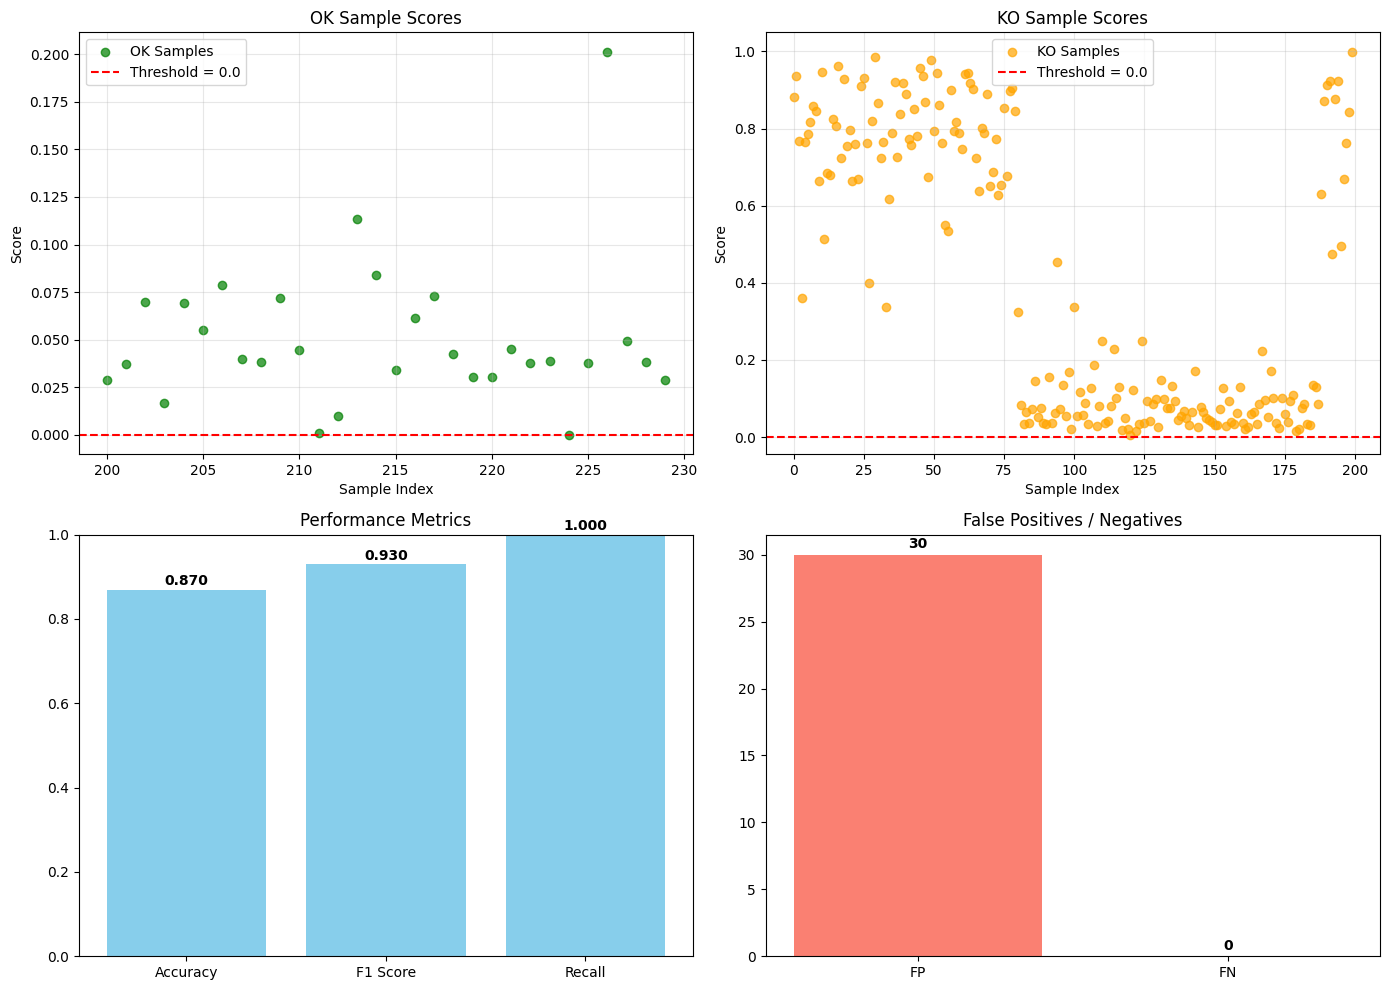

In [24]:
def load_experiment(results_base_path):
    exp_name = 'Original (02_224)'
    folder_name, subfolder = 'BTAD_02_WR50_L2-3', 'btad_02'
    scores_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/scores.npy")
    
    all_data = {}

    if os.path.exists(scores_path):
        scores = np.load(scores_path)
        folder_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/")
        if os.path.exists(folder_path):
            files = sorted(os.listdir(folder_path))
            png_files = [f for f in files if f.endswith('.png')]
            labels = [0 if "_OK_" in f else 1 for f in png_files if "_OK_" in f or "_KO_" in f]
            if len(scores) == len(labels):
                all_data[exp_name] = {
                    'scores': scores,
                    'labels': np.array(labels)
                }

    return all_data

def test_experiment(all_data):
    threshold = 0.0
    results = []
    metrics_data = {}

    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        preds = (scores >= threshold).astype(int)

        tp = np.sum((preds == 1) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))

        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        num_ok = np.sum(labels == 0)
        num_ko = np.sum(labels == 1)

        results.append({
            'Experiment': exp_name,
            'Threshold': threshold,
            'OK Count': num_ok,
            'KO Count': num_ko,
            'OK %': round(num_ok / len(labels) * 100, 1),
            'KO %': round(num_ko / len(labels) * 100, 1),
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(f1, 4),
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
        })

        metrics_data[exp_name] = {
            'scores': scores,
            'labels': labels,
            'threshold': threshold
        }

    return pd.DataFrame(results), metrics_data

def create_plot(results_df, all_data):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    exp_name = results_df['Experiment'].iloc[0]
    color = 'blue'
    
    scores = all_data[exp_name]['scores']
    labels = all_data[exp_name]['labels']
    threshold = results_df['Threshold'].iloc[0]

    ok_idx = np.where(labels == 0)[0]
    ko_idx = np.where(labels == 1)[0]

    axes[0,0].scatter(ok_idx, scores[labels == 0], alpha=0.7, label='OK Samples', color='green')
    axes[0,0].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    axes[0,0].set_title('OK Sample Scores')
    axes[0,0].set_xlabel('Sample Index')
    axes[0,0].set_ylabel('Score')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].scatter(ko_idx, scores[labels == 1], alpha=0.7, label='KO Samples', color='orange')
    axes[0,1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    axes[0,1].set_title('KO Sample Scores')
    axes[0,1].set_xlabel('Sample Index')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    metrics = ['Accuracy', 'F1 Score', 'Recall']
    values = [results_df[m].iloc[0] for m in metrics]
    axes[1,0].bar(metrics, values, color='skyblue')
    for i, v in enumerate(values):
        axes[1,0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].set_title('Performance Metrics')

    axes[1,1].bar(['FP', 'FN'], [results_df['FP'].iloc[0], results_df['FN'].iloc[0]], color='salmon')
    axes[1,1].set_title('False Positives / Negatives')
    for i, v in enumerate([results_df['FP'].iloc[0], results_df['FN'].iloc[0]]):
        axes[1,1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
    results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"

all_data = load_experiment(results_base_path)

if all_data:
    df_result, metrics = test_experiment(all_data)
    display(df_result)
    create_plot(df_result, all_data)
else:
    print("❌ 분석할 데이터가 없습니다.")

🔍 실험 데이터 로드 중...
검사 중: Original (02)
  경로: /home/lkmsdf159/patchcore-inspection/results/project/BTAD_02_WR50_L2-3/segmentation_images/btad_02/scores.npy
  ✅ 로드 성공: 230개 샘플
검사 중: Histogram EQ (02_wood)
  경로: /home/lkmsdf159/patchcore-inspection/results/project/BTAD_02_histogram_eq_wood_WR50_L2-3/segmentation_images/btad_11_histogram_eq_wood/scores.npy
  ✅ 로드 성공: 230개 샘플

✅ 2개 실험 로드 완료!

📋 실험 결과:
            Experiment  Total Samples  OK Count  KO Count  OK %  KO %  Accuracy  Precision  Recall  F1 Score    AUC  TP  TN  FP  FN  Score Mean  Score Std
         Original (02)            230        30       200  13.0  87.0    0.8696     0.8696     1.0    0.9302 0.8153 200   0  30   0      0.3599     0.3616
Histogram EQ (02_wood)            230        30       200  13.0  87.0    0.8696     0.8696     1.0    0.9302 0.8365 200   0  30   0      0.2855     0.2928


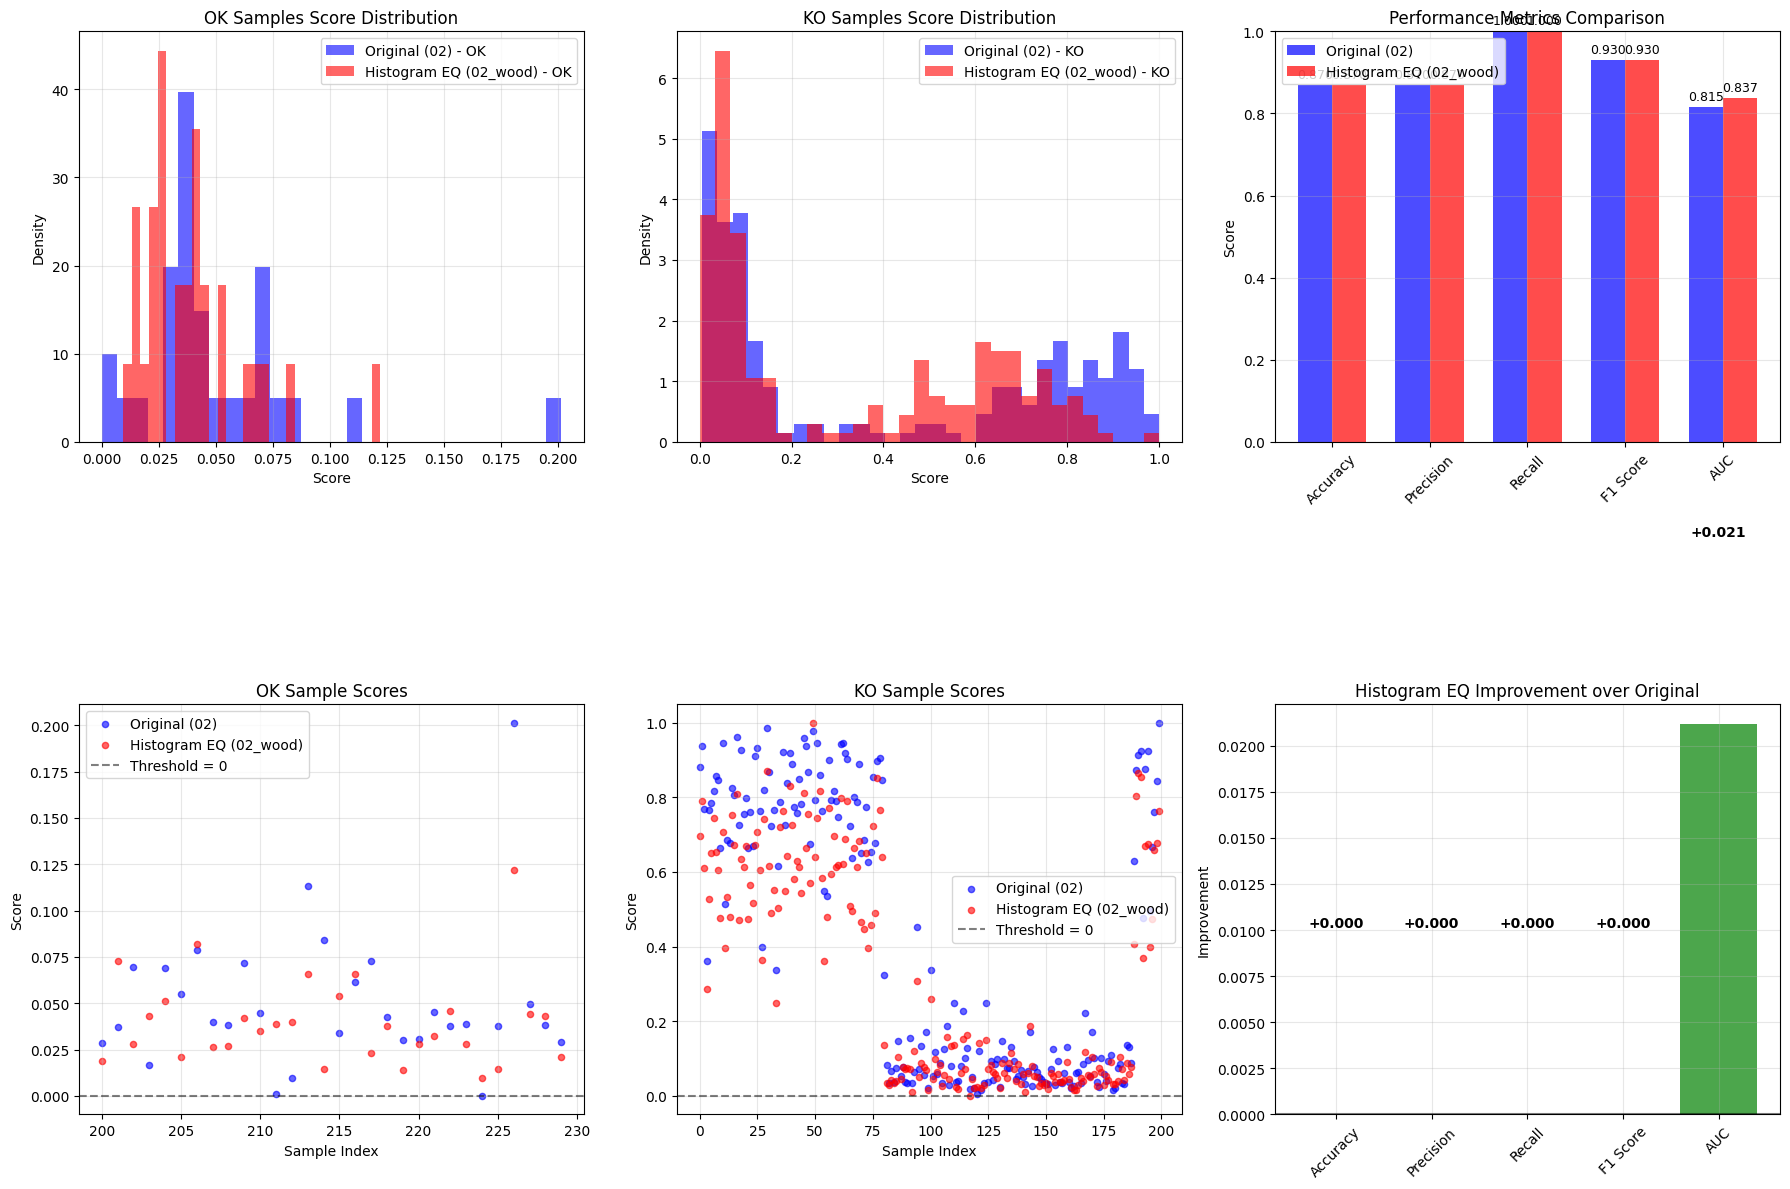


📊 실험 비교 요약
🔵 Original (02)
   Accuracy: 0.8696, F1: 0.9302, AUC: 0.8153
🔴 Histogram EQ (02_wood)
   Accuracy: 0.8696, F1: 0.9302, AUC: 0.8365

📈 개선도:
   Accuracy: +0.0000
   F1 Score: +0.0000
   AUC: +0.0212

🤝 두 방법이 비슷합니다!


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_experiments(results_base_path):
    """Original과 Histogram EQ 실험 로드"""
    
    experiments = {
        'Original (02)': {
            'folder_name': 'BTAD_02_WR50_L2-3',
            'subfolder': 'btad_02'
        },
        'Histogram EQ (02_wood)': {
            'folder_name': 'BTAD_02_histogram_eq_wood_WR50_L2-3',
            'subfolder': 'btad_11_histogram_eq_wood'
        }
    }
    all_data = {}
    
    for exp_name, config in experiments.items():
        folder_name = config['folder_name']
        subfolder = config['subfolder']
        
        scores_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/scores.npy")
        
        print(f"검사 중: {exp_name}")
        print(f"  경로: {scores_path}")
        
        if os.path.exists(scores_path):
            try:
                scores = np.load(scores_path)
                folder_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/")
                
                if os.path.exists(folder_path):
                    files = sorted(os.listdir(folder_path))
                    png_files = [f for f in files if f.endswith('.png')]
                    
                    # 라벨 추출 (OK=0, KO=1)
                    labels = []
                    for f in png_files:
                        if "_OK_" in f:
                            labels.append(0)
                        elif "_KO_" in f:
                            labels.append(1)
                    
                    if len(scores) == len(labels):
                        all_data[exp_name] = {
                            'scores': scores,
                            'labels': np.array(labels),
                            'files': png_files
                        }
                        print(f"  ✅ 로드 성공: {len(scores)}개 샘플")
                    else:
                        print(f"  ❌ 점수와 라벨 개수 불일치: {len(scores)} vs {len(labels)}")
                else:
                    print(f"  ❌ 폴더 없음: {folder_path}")
            except Exception as e:
                print(f"  ❌ 로드 실패: {e}")
        else:
            print(f"  ❌ 파일 없음: {scores_path}")
    
    return all_data

def compare_experiments(all_data):
    """두 실험 비교 분석"""
    
    threshold = 0.0
    results = []
    
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        preds = (scores >= threshold).astype(int)
        
        # Confusion Matrix
        tp = np.sum((preds == 1) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        
        # Metrics
        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # ROC-AUC
        from sklearn.metrics import roc_auc_score
        try:
            auc = roc_auc_score(labels, scores)
        except:
            auc = 0
        
        num_ok = np.sum(labels == 0)
        num_ko = np.sum(labels == 1)
        
        results.append({
            'Experiment': exp_name,
            'Total Samples': len(labels),
            'OK Count': num_ok,
            'KO Count': num_ko,
            'OK %': round(num_ok / len(labels) * 100, 1),
            'KO %': round(num_ko / len(labels) * 100, 1),
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(f1, 4),
            'AUC': round(auc, 4),
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
            'Score Mean': round(np.mean(scores), 4),
            'Score Std': round(np.std(scores), 4)
        })
    
    return pd.DataFrame(results)

def create_comparison_plot(results_df, all_data):
    """비교 시각화"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    exp_names = list(all_data.keys())
    colors = ['blue', 'red']
    
    # 1. 점수 분포 비교
    for i, (exp_name, color) in enumerate(zip(exp_names, colors)):
        data = all_data[exp_name]
        scores = data['scores']
        labels = data['labels']
        
        ok_scores = scores[labels == 0]
        ko_scores = scores[labels == 1]
        
        axes[0, 0].hist(ok_scores, alpha=0.6, label=f'{exp_name} - OK', 
                       color=color, bins=30, density=True)
        axes[0, 1].hist(ko_scores, alpha=0.6, label=f'{exp_name} - KO', 
                       color=color, bins=30, density=True)
    
    axes[0, 0].set_title('OK Samples Score Distribution')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('KO Samples Score Distribution')
    axes[0, 1].set_xlabel('Score')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 2. 성능 메트릭 비교
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    x = np.arange(len(metrics))
    width = 0.35
    
    if len(results_df) >= 2:
        values1 = [results_df.iloc[0][m] for m in metrics]
        values2 = [results_df.iloc[1][m] for m in metrics]
        
        bars1 = axes[0, 2].bar(x - width/2, values1, width, label=exp_names[0], color=colors[0], alpha=0.7)
        bars2 = axes[0, 2].bar(x + width/2, values2, width, label=exp_names[1], color=colors[1], alpha=0.7)
        
        # 값 표시
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    axes[0, 2].set_title('Performance Metrics Comparison')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(metrics, rotation=45)
    axes[0, 2].legend()
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 3. 샘플별 점수 비교
    for i, (exp_name, color) in enumerate(zip(exp_names, colors)):
        data = all_data[exp_name]
        scores = data['scores']
        labels = data['labels']
        
        # OK 샘플
        ok_idx = np.where(labels == 0)[0]
        axes[1, 0].scatter(ok_idx, scores[labels == 0], alpha=0.6, 
                          label=f'{exp_name}', color=color, s=20)
        
        # KO 샘플
        ko_idx = np.where(labels == 1)[0]
        axes[1, 1].scatter(ko_idx, scores[labels == 1], alpha=0.6, 
                          label=f'{exp_name}', color=color, s=20)
    
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Threshold = 0')
    axes[1, 0].set_title('OK Sample Scores')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Threshold = 0')
    axes[1, 1].set_title('KO Sample Scores')
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 4. 개선 분석
    if len(results_df) >= 2:
        orig_row = results_df.iloc[0]
        hist_row = results_df.iloc[1]
        
        improvements = {}
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']:
            improvement = hist_row[metric] - orig_row[metric]
            improvements[metric] = improvement
        
        metric_names = list(improvements.keys())
        improvement_values = list(improvements.values())
        colors_imp = ['green' if v > 0 else 'red' for v in improvement_values]
        
        bars = axes[1, 2].bar(metric_names, improvement_values, color=colors_imp, alpha=0.7)
        axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 2].set_title('Histogram EQ Improvement over Original')
        axes[1, 2].set_ylabel('Improvement')
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        # 값 표시
        for bar, value in zip(bars, improvement_values):
            height = bar.get_height()
            axes[1, 2].text(bar.get_x() + bar.get_width()/2., 
                           height + (0.01 if height >= 0 else -0.01),
                           f'{value:+.3f}', ha='center', 
                           va='bottom' if height >= 0 else 'top', fontweight='bold')
        
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_summary(results_df):
    """요약 통계 출력"""
    print("\n" + "="*60)
    print("📊 실험 비교 요약")
    print("="*60)
    
    if len(results_df) >= 2:
        orig = results_df.iloc[0]
        hist = results_df.iloc[1]
        
        print(f"🔵 {orig['Experiment']}")
        print(f"   Accuracy: {orig['Accuracy']:.4f}, F1: {orig['F1 Score']:.4f}, AUC: {orig['AUC']:.4f}")
        
        print(f"🔴 {hist['Experiment']}")
        print(f"   Accuracy: {hist['Accuracy']:.4f}, F1: {hist['F1 Score']:.4f}, AUC: {hist['AUC']:.4f}")
        
        print(f"\n📈 개선도:")
        print(f"   Accuracy: {hist['Accuracy'] - orig['Accuracy']:+.4f}")
        print(f"   F1 Score: {hist['F1 Score'] - orig['F1 Score']:+.4f}")
        print(f"   AUC: {hist['AUC'] - orig['AUC']:+.4f}")
        
        # 더 나은 방법 판단
        if hist['F1 Score'] > orig['F1 Score']:
            print(f"\n🏆 Histogram Equalization이 더 우수합니다!")
        elif hist['F1 Score'] < orig['F1 Score']:
            print(f"\n🏆 Original이 더 우수합니다!")
        else:
            print(f"\n🤝 두 방법이 비슷합니다!")

# 실행
results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"

print("🔍 실험 데이터 로드 중...")
all_data = load_experiments(results_base_path)

if len(all_data) >= 2:
    print(f"\n✅ {len(all_data)}개 실험 로드 완료!")
    
    # 비교 분석
    df_result = compare_experiments(all_data)
    
    print("\n📋 실험 결과:")
    print(df_result.to_string(index=False))
    
    # 시각화
    create_comparison_plot(df_result, all_data)
    
    # 요약
    print_summary(df_result)
    
elif len(all_data) == 1:
    print(f"⚠️  1개 실험만 로드됨: {list(all_data.keys())[0]}")
    print("두 실험을 비교하려면 둘 다 필요합니다.")
else:
    print("❌ 분석할 데이터가 없습니다.")
    print("다음 경로들을 확인해주세요:")
    print("- BTAD_02_WR50_L2-3/segmentation_images/btad_02/scores.npy")
    print("- BTAD_02_histogram_eq_wood_WR50_L2-3/segmentation_images/btad_02/scores.npy")

🔍 실험 데이터 로드 중...
검사 중: Original (01)
  경로: /home/lkmsdf159/patchcore-inspection/results/project/BTAD01_224_WR50_L2-3/segmentation_images/btad_01/scores.npy
  ✅ 로드 성공: 70개 샘플
검사 중: Histogram EQ (01_ring)
  경로: /home/lkmsdf159/patchcore-inspection/results/project/BTAD_01_histogram_eq_ring_WR50_L2-3/segmentation_images/btad_10_histogram_eq_ring/scores.npy
  ✅ 로드 성공: 70개 샘플

✅ 2개 실험 로드 완료!

📋 실험 결과:
            Experiment  Total Samples  OK Count  KO Count  OK %  KO %  Accuracy  Precision  Recall  F1 Score    AUC  TP  TN  FP  FN  Score Mean  Score Std
         Original (01)             70        21        49  30.0  70.0       0.7        0.7     1.0    0.8235 0.9728  49   0  21   0      0.3749     0.3429
Histogram EQ (01_ring)             70        21        49  30.0  70.0       0.7        0.7     1.0    0.8235 0.9757  49   0  21   0      0.3147     0.2918


/tmp/ipykernel_2797/869866369.py:238: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


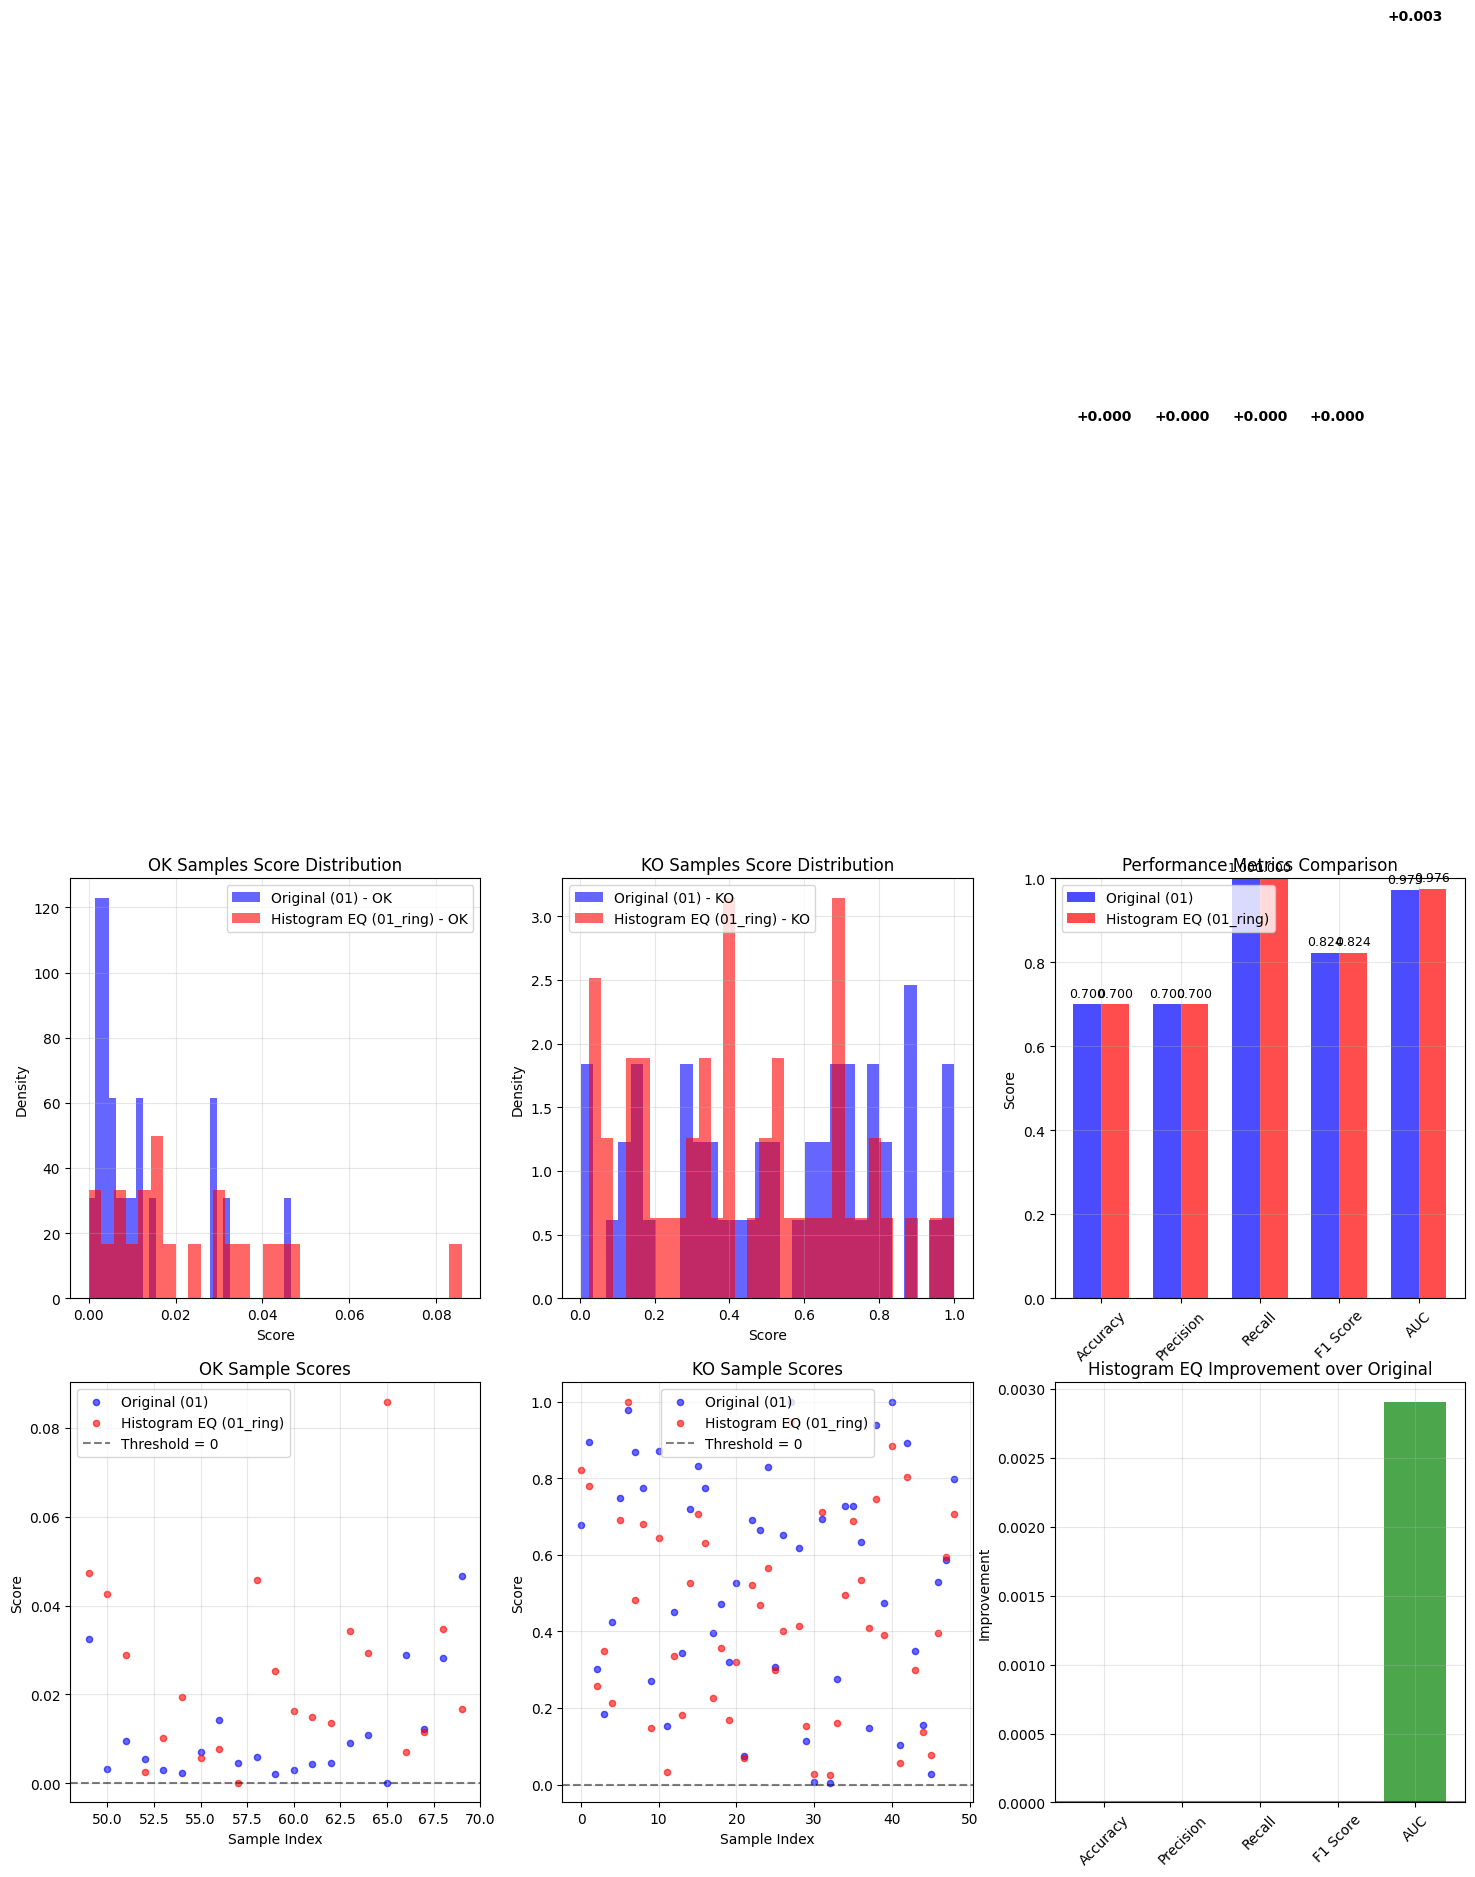


📊 실험 비교 요약
🔵 Original (01)
   Accuracy: 0.7000, F1: 0.8235, AUC: 0.9728
🔴 Histogram EQ (01_ring)
   Accuracy: 0.7000, F1: 0.8235, AUC: 0.9757

📈 개선도:
   Accuracy: +0.0000
   F1 Score: +0.0000
   AUC: +0.0029

🤝 두 방법이 비슷합니다!


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_experiments(results_base_path):
    """Original과 Histogram EQ 실험 로드"""
    
    experiments = {
        'Original (01)': {
            'folder_name': 'BTAD01_224_WR50_L2-3',
            'subfolder': 'btad_01'
        },
        'Histogram EQ (01_ring)': {
            'folder_name': 'BTAD_01_histogram_eq_ring_WR50_L2-3',
            'subfolder': 'btad_10_histogram_eq_ring'
        }
    }
    all_data = {}
    
    for exp_name, config in experiments.items():
        folder_name = config['folder_name']
        subfolder = config['subfolder']
        
        scores_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/scores.npy")
        
        print(f"검사 중: {exp_name}")
        print(f"  경로: {scores_path}")
        
        if os.path.exists(scores_path):
            try:
                scores = np.load(scores_path)
                folder_path = os.path.join(results_base_path, folder_name, f"segmentation_images/{subfolder}/")
                
                if os.path.exists(folder_path):
                    files = sorted(os.listdir(folder_path))
                    png_files = [f for f in files if f.endswith('.png')]
                    
                    # 라벨 추출 (OK=0, KO=1)
                    labels = []
                    for f in png_files:
                        if "_OK_" in f:
                            labels.append(0)
                        elif "_KO_" in f:
                            labels.append(1)
                    
                    if len(scores) == len(labels):
                        all_data[exp_name] = {
                            'scores': scores,
                            'labels': np.array(labels),
                            'files': png_files
                        }
                        print(f"  ✅ 로드 성공: {len(scores)}개 샘플")
                    else:
                        print(f"  ❌ 점수와 라벨 개수 불일치: {len(scores)} vs {len(labels)}")
                else:
                    print(f"  ❌ 폴더 없음: {folder_path}")
            except Exception as e:
                print(f"  ❌ 로드 실패: {e}")
        else:
            print(f"  ❌ 파일 없음: {scores_path}")
    
    return all_data

def compare_experiments(all_data):
    """두 실험 비교 분석"""
    
    threshold = 0.0
    results = []
    
    for exp_name, data in all_data.items():
        scores = data['scores']
        labels = data['labels']
        preds = (scores >= threshold).astype(int)
        
        # Confusion Matrix
        tp = np.sum((preds == 1) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        
        # Metrics
        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # ROC-AUC
        from sklearn.metrics import roc_auc_score
        try:
            auc = roc_auc_score(labels, scores)
        except:
            auc = 0
        
        num_ok = np.sum(labels == 0)
        num_ko = np.sum(labels == 1)
        
        results.append({
            'Experiment': exp_name,
            'Total Samples': len(labels),
            'OK Count': num_ok,
            'KO Count': num_ko,
            'OK %': round(num_ok / len(labels) * 100, 1),
            'KO %': round(num_ko / len(labels) * 100, 1),
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(f1, 4),
            'AUC': round(auc, 4),
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
            'Score Mean': round(np.mean(scores), 4),
            'Score Std': round(np.std(scores), 4)
        })
    
    return pd.DataFrame(results)

def create_comparison_plot(results_df, all_data):
    """비교 시각화"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    exp_names = list(all_data.keys())
    colors = ['blue', 'red']
    
    # 1. 점수 분포 비교
    for i, (exp_name, color) in enumerate(zip(exp_names, colors)):
        data = all_data[exp_name]
        scores = data['scores']
        labels = data['labels']
        
        ok_scores = scores[labels == 0]
        ko_scores = scores[labels == 1]
        
        axes[0, 0].hist(ok_scores, alpha=0.6, label=f'{exp_name} - OK', 
                       color=color, bins=30, density=True)
        axes[0, 1].hist(ko_scores, alpha=0.6, label=f'{exp_name} - KO', 
                       color=color, bins=30, density=True)
    
    axes[0, 0].set_title('OK Samples Score Distribution')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('KO Samples Score Distribution')
    axes[0, 1].set_xlabel('Score')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 2. 성능 메트릭 비교
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    x = np.arange(len(metrics))
    width = 0.35
    
    if len(results_df) >= 2:
        values1 = [results_df.iloc[0][m] for m in metrics]
        values2 = [results_df.iloc[1][m] for m in metrics]
        
        bars1 = axes[0, 2].bar(x - width/2, values1, width, label=exp_names[0], color=colors[0], alpha=0.7)
        bars2 = axes[0, 2].bar(x + width/2, values2, width, label=exp_names[1], color=colors[1], alpha=0.7)
        
        # 값 표시
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    axes[0, 2].set_title('Performance Metrics Comparison')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(metrics, rotation=45)
    axes[0, 2].legend()
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 3. 샘플별 점수 비교
    for i, (exp_name, color) in enumerate(zip(exp_names, colors)):
        data = all_data[exp_name]
        scores = data['scores']
        labels = data['labels']
        
        # OK 샘플
        ok_idx = np.where(labels == 0)[0]
        axes[1, 0].scatter(ok_idx, scores[labels == 0], alpha=0.6, 
                          label=f'{exp_name}', color=color, s=20)
        
        # KO 샘플
        ko_idx = np.where(labels == 1)[0]
        axes[1, 1].scatter(ko_idx, scores[labels == 1], alpha=0.6, 
                          label=f'{exp_name}', color=color, s=20)
    
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Threshold = 0')
    axes[1, 0].set_title('OK Sample Scores')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Threshold = 0')
    axes[1, 1].set_title('KO Sample Scores')
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 4. 개선 분석
    if len(results_df) >= 2:
        orig_row = results_df.iloc[0]
        hist_row = results_df.iloc[1]
        
        improvements = {}
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']:
            improvement = hist_row[metric] - orig_row[metric]
            improvements[metric] = improvement
        
        metric_names = list(improvements.keys())
        improvement_values = list(improvements.values())
        colors_imp = ['green' if v > 0 else 'red' for v in improvement_values]
        
        bars = axes[1, 2].bar(metric_names, improvement_values, color=colors_imp, alpha=0.7)
        axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 2].set_title('Histogram EQ Improvement over Original')
        axes[1, 2].set_ylabel('Improvement')
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        # 값 표시
        for bar, value in zip(bars, improvement_values):
            height = bar.get_height()
            axes[1, 2].text(bar.get_x() + bar.get_width()/2., 
                           height + (0.01 if height >= 0 else -0.01),
                           f'{value:+.3f}', ha='center', 
                           va='bottom' if height >= 0 else 'top', fontweight='bold')
        
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_summary(results_df):
    """요약 통계 출력"""
    print("\n" + "="*60)
    print("📊 실험 비교 요약")
    print("="*60)
    
    if len(results_df) >= 2:
        orig = results_df.iloc[0]
        hist = results_df.iloc[1]
        
        print(f"🔵 {orig['Experiment']}")
        print(f"   Accuracy: {orig['Accuracy']:.4f}, F1: {orig['F1 Score']:.4f}, AUC: {orig['AUC']:.4f}")
        
        print(f"🔴 {hist['Experiment']}")
        print(f"   Accuracy: {hist['Accuracy']:.4f}, F1: {hist['F1 Score']:.4f}, AUC: {hist['AUC']:.4f}")
        
        print(f"\n📈 개선도:")
        print(f"   Accuracy: {hist['Accuracy'] - orig['Accuracy']:+.4f}")
        print(f"   F1 Score: {hist['F1 Score'] - orig['F1 Score']:+.4f}")
        print(f"   AUC: {hist['AUC'] - orig['AUC']:+.4f}")
        
        # 더 나은 방법 판단
        if hist['F1 Score'] > orig['F1 Score']:
            print(f"\n🏆 Histogram Equalization이 더 우수합니다!")
        elif hist['F1 Score'] < orig['F1 Score']:
            print(f"\n🏆 Original이 더 우수합니다!")
        else:
            print(f"\n🤝 두 방법이 비슷합니다!")

# 실행
results_base_path = "/home/lkmsdf159/patchcore-inspection/results/project"

print("🔍 실험 데이터 로드 중...")
all_data = load_experiments(results_base_path)

if len(all_data) >= 2:
    print(f"\n✅ {len(all_data)}개 실험 로드 완료!")
    
    # 비교 분석
    df_result = compare_experiments(all_data)
    
    print("\n📋 실험 결과:")
    print(df_result.to_string(index=False))
    
    # 시각화
    create_comparison_plot(df_result, all_data)
    
    # 요약
    print_summary(df_result)
    
elif len(all_data) == 1:
    print(f"⚠️  1개 실험만 로드됨: {list(all_data.keys())[0]}")
    print("두 실험을 비교하려면 둘 다 필요합니다.")
else:
    print("❌ 분석할 데이터가 없습니다.")
    print("다음 경로들을 확인해주세요:")
    print("- BTAD_02_WR50_L2-3/segmentation_images/btad_02/scores.npy")
    print("- BTAD_02_histogram_eq_wood_WR50_L2-3/segmentation_images/btad_02/scores.npy")

In [13]:
def apply_brightness(image, brightness=0.1):
    """밝기 조정"""
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(0.5 + brightness)


def create_preprocessed_dataset_simple(source_path, target_path, preprocessing_type="brightness"):
    """전체 데이터셋에 전처리 적용 (ground_truth 제외)"""
    
    preprocessing_funcs = {
        "brightness": lambda img: apply_brightness(img, brightness=0.1),
        "histogram_eq": lambda img: apply_histogram_equalization(img),
        "clahe": lambda img: apply_clahe(img, clip_limit=2.0)
    }
    
    if preprocessing_type not in preprocessing_funcs:
        raise ValueError(f"지원하지 않는 전처리 타입: {preprocessing_type}")
    
    preprocess_func = preprocessing_funcs[preprocessing_type]
    
    source_root = Path(source_path)
    target_root = Path(target_path)
    
    # 대상 폴더 생성
    target_root.mkdir(parents=True, exist_ok=True)
    
    # 처리할 폴더들 (train/test)
    splits = ["train", "test"]
    
    total_files = 0
    processed_files = 0
    
    # 전체 파일 수 계산
    for split in splits:
        split_path = source_root / split
        if split_path.exists():
            for class_dir in split_path.iterdir():
                if class_dir.is_dir():
                    image_files = list(class_dir.glob("*.bmp")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpg"))
                    total_files += len(image_files)
    
    print(f"총 {total_files}개 파일 처리 시작...")
    
    # 각 split (train/test) 처리
    for split in splits:
        split_path = source_root / split
        if not split_path.exists():
            continue
            
        target_split_path = target_root / split
        target_split_path.mkdir(exist_ok=True)
        
        # 각 클래스 폴더 처리 (ok, ko 등)
        for class_dir in split_path.iterdir():
            if not class_dir.is_dir():
                continue
                
            class_name = class_dir.name
            target_class_path = target_split_path / class_name
            target_class_path.mkdir(exist_ok=True)
            
            # 이미지 파일들 처리
            image_files = list(class_dir.glob("*.bmp")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpg"))
            
            for img_file in tqdm(image_files, desc=f"Processing {split}/{class_name}"):
                try:
                    # 이미지 로드
                    image = Image.open(img_file).convert("RGB")
                    
                    # 전처리 적용
                    processed_image = preprocess_func(image)
                    
                    # 저장 (원본과 같은 이름)
                    target_file = target_class_path / img_file.name
                    processed_image.save(target_file)
                    
                    processed_files += 1
                    
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
    
    print(f"완료! {processed_files}/{total_files} 파일 처리됨")
    print(f"결과 저장 위치: {target_path}")
    print("Note: ground_truth 폴더는 권한 문제로 복사하지 않았습니다.")

def create_one_preprocessing(base_source_path, base_target_path, folder_name, preprocessing_type):
    """단일 전처리 버전 생성"""
    print(f"\n{'='*50}")
    print(f"Creating {folder_name} with {preprocessing_type} preprocessing...")
    print(f"{'='*50}")
    
    target_path = os.path.join(base_target_path, folder_name)
    create_preprocessed_dataset_simple(base_source_path, target_path, preprocessing_type)

def create_all_preprocessing_simple(base_source_path, base_target_path):
    """3가지 전처리 버전을 모두 생성 (간단 버전)"""
    
    preprocessing_configs = [
        ("03_brightness", "brightness"),
        ("04_histogram_eq", "histogram_eq"), 
        ("05_clahe", "clahe")
    ]
    
    for folder_name, preprocessing_type in preprocessing_configs:
        create_one_preprocessing(base_source_path, base_target_path, folder_name, preprocessing_type)
    
    print(f"\n{'='*50}")
    print("모든 전처리 완료!")
    print("생성된 폴더들:")
    print("- 03_brightness: 밝기 +0.1 버전")
    print("- 04_histogram_eq: 히스토그램 평활화 버전")  
    print("- 05_clahe: CLAHE 버전")
    print("이제 각 폴더로 PatchCore 훈련/테스트를 진행하세요!")
    print(f"{'='*50}")

base_source = "/mnt/d/BTech_Dataset_transformed/01"
base_target = "/mnt/d/BTech_Dataset_transformed"

# 1. 밝기 조정
create_one_preprocessing(base_source, base_target, "09_brightness)0.5", "brightness")



Creating 09_brightness)0.5 with brightness preprocessing...
총 470개 파일 처리 시작...


Processing train/ok:   6%|▋         | 25/400 [00:06<01:41,  3.69it/s]


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


In [ ]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


Total scores: 70
Score range: 0.0000 - 1.0000
GT labels: 70
OK count: 21
KO count: 49

=== Score Distribution ===
OK scores (21개):
  Mean: 0.4187
  Std: 0.3318
  Min: 0.0000
  Max: 1.0000
  Median: 0.4709

KO scores (49개):
  Mean: 0.3561
  Std: 0.3459
  Min: 0.0020
  Max: 0.9998
  Median: 0.3084

=== Performance (Threshold: 0.2000) ===
Accuracy: 0.486
Precision: 0.667
Recall: 0.531
TP: 26, TN: 8, FP: 13, FN: 23

=== Recommended Thresholds ===
OK 95th percentile: 0.8950
KO 5th percentile: 0.0030
Mean threshold: 0.3874
Threshold 0.2500: Accuracy=0.486, Recall=0.531, FN=23
Threshold 0.3000: Accuracy=0.486, Recall=0.510, FN=24
Threshold 0.3500: Accuracy=0.443, Recall=0.429, FN=28


/tmp/ipykernel_938/2765527820.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ok_scores, label='OK', hist=False, color='green')
/tmp/ipykernel_938/2765527820.py:122: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ko_scores, label='KO', hist=False, color='red')


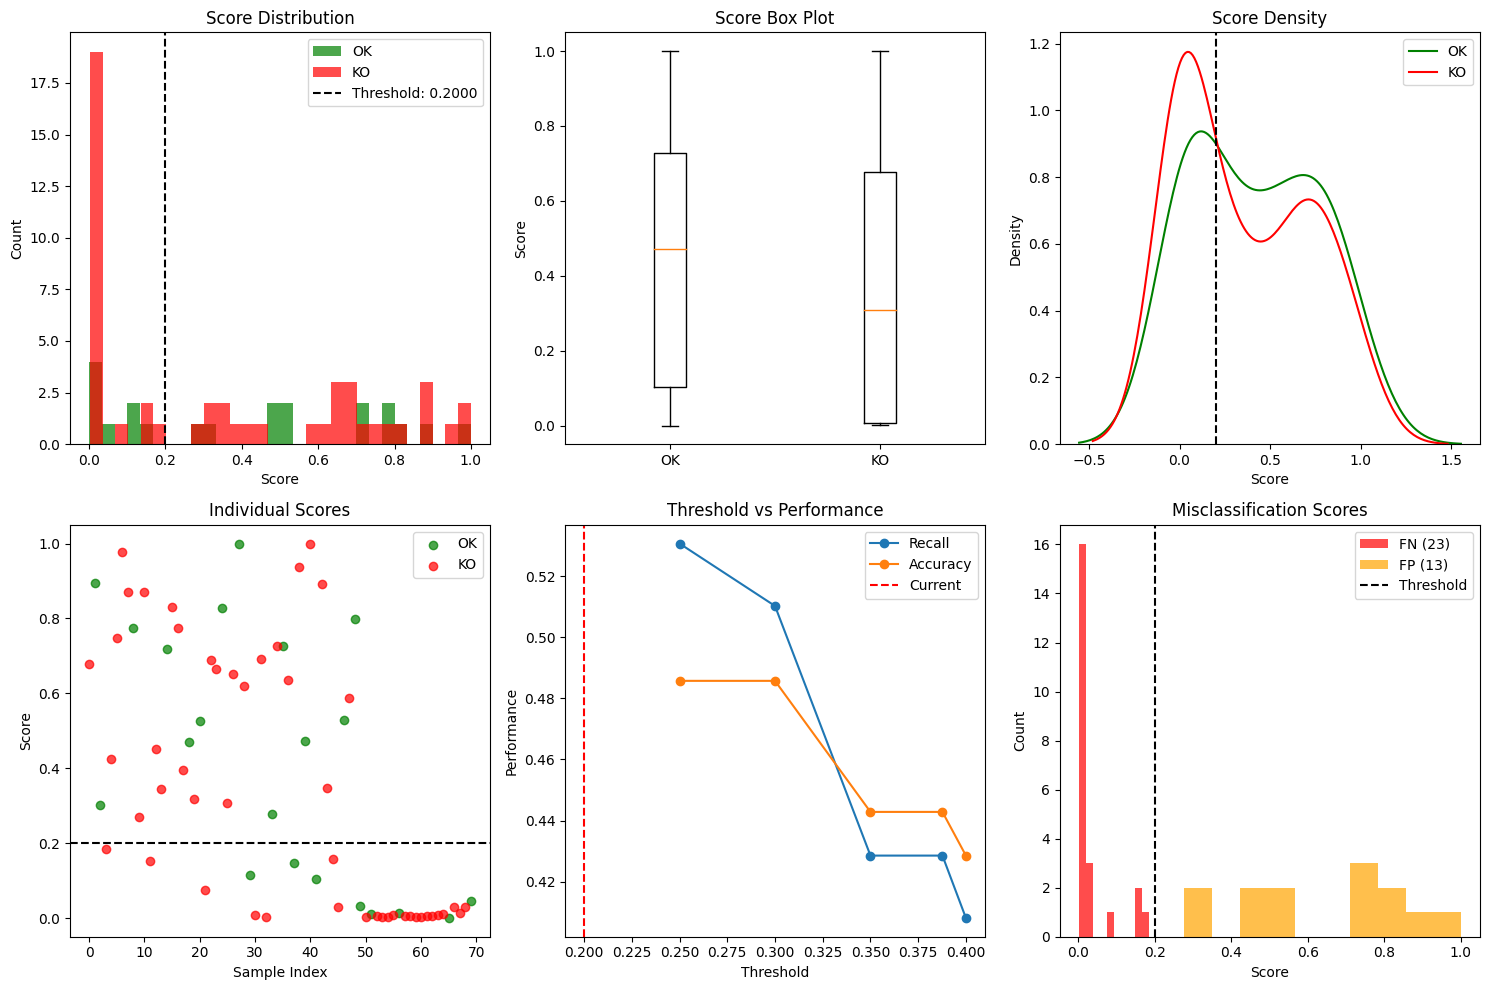


=== Detailed Analysis ===
False Negative scores: [0.18345022 0.152636   0.07531806 0.00668353 0.00358694 0.15629905
 0.02846462 0.00313705 0.00538423 0.00304141 0.00237083 0.00697921
 0.00457896 0.00597135 0.00201148 0.00292371 0.00438061 0.00450058
 0.00900851 0.01093398 0.02882679 0.01228449 0.02827504]
FN score range: 0.0020 - 0.1835
False Positive scores: [0.89499557 0.30206224 0.77534    0.7184549  0.47087383 0.5274177
 0.8283637  1.         0.27718937 0.7266157  0.4739693  0.52994555
 0.7986069 ]
FP score range: 0.2772 - 1.0000

Overlap analysis:
OK max: 1.0000
KO min: 0.0020
Overlap: True


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# scores.npy 파일 로드
scores_path = "/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_224_WR50_L2-3/segmentation_images/btad_01/scores.npy"
scores = np.load(scores_path)

print(f"Total scores: {len(scores)}")
print(f"Score range: {scores.min():.4f} - {scores.max():.4f}")

# 이미지 파일에서 GT 정보 추출
results_path = "/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_224_WR50_L2-3/segmentation_images/btad_01"
image_files = glob.glob(os.path.join(results_path, "**/*.png"), recursive=True)

# GT 라벨 추출
gt_labels = []
for img_file in image_files:
    filename = os.path.basename(img_file)
    if '_KO_vs_' in filename:
        gt_labels.append(1)
    elif '_OK_vs_' in filename:
        gt_labels.append(0)

gt_labels = np.array(gt_labels)

print(f"GT labels: {len(gt_labels)}")
print(f"OK count: {np.sum(gt_labels == 0)}")
print(f"KO count: {np.sum(gt_labels == 1)}")

# scores와 gt_labels 길이 맞추기
min_len = min(len(scores), len(gt_labels))
scores = scores[:min_len]
gt_labels = gt_labels[:min_len]

# OK vs KO 분리
ok_scores = scores[gt_labels == 0]
ko_scores = scores[gt_labels == 1]

print("\n=== Score Distribution ===")
print(f"OK scores ({len(ok_scores)}개):")
print(f"  Mean: {ok_scores.mean():.4f}")
print(f"  Std: {ok_scores.std():.4f}")
print(f"  Min: {ok_scores.min():.4f}")
print(f"  Max: {ok_scores.max():.4f}")
print(f"  Median: {np.median(ok_scores):.4f}")

print(f"\nKO scores ({len(ko_scores)}개):")
print(f"  Mean: {ko_scores.mean():.4f}")
print(f"  Std: {ko_scores.std():.4f}")
print(f"  Min: {ko_scores.min():.4f}")
print(f"  Max: {ko_scores.max():.4f}")
print(f"  Median: {np.median(ko_scores):.4f}")

# 현재 threshold에서의 분류 성능
threshold = 0.2
predictions = (scores > threshold).astype(int)

tp = np.sum((gt_labels == 1) & (predictions == 1))
tn = np.sum((gt_labels == 0) & (predictions == 0))
fp = np.sum((gt_labels == 0) & (predictions == 1))
fn = np.sum((gt_labels == 1) & (predictions == 0))

accuracy = (tp + tn) / len(scores)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n=== Performance (Threshold: {threshold:.4f}) ===")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

# 권장 threshold 계산
ok_95 = np.percentile(ok_scores, 95)
ko_5 = np.percentile(ko_scores, 5)
mean_threshold = (ok_scores.mean() + ko_scores.mean()) / 2

print(f"\n=== Recommended Thresholds ===")
print(f"OK 95th percentile: {ok_95:.4f}")
print(f"KO 5th percentile: {ko_5:.4f}")
print(f"Mean threshold: {mean_threshold:.4f}")

# 다른 threshold에서의 성능 예측
for new_threshold in [0.25, 0.30, 0.35]:
    new_pred = (scores > new_threshold).astype(int)
    new_tp = np.sum((gt_labels == 1) & (new_pred == 1))
    new_tn = np.sum((gt_labels == 0) & (new_pred == 0))
    new_fp = np.sum((gt_labels == 0) & (new_pred == 1))
    new_fn = np.sum((gt_labels == 1) & (new_pred == 0))
    
    new_accuracy = (new_tp + new_tn) / len(scores)
    new_recall = new_tp / (new_tp + new_fn) if (new_tp + new_fn) > 0 else 0
    
    print(f"Threshold {new_threshold:.4f}: Accuracy={new_accuracy:.3f}, Recall={new_recall:.3f}, FN={new_fn}")

# 시각화
plt.figure(figsize=(15, 10))

# 1. Score 분포
plt.subplot(2, 3, 1)
plt.hist(ok_scores, bins=30, alpha=0.7, label='OK', color='green')
plt.hist(ko_scores, bins=30, alpha=0.7, label='KO', color='red')
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score Distribution')
plt.legend()

# 2. 박스플롯
plt.subplot(2, 3, 2)
plt.boxplot([ok_scores, ko_scores], labels=['OK', 'KO'])
plt.ylabel('Score')
plt.title('Score Box Plot')

# 3. 밀도 플롯
plt.subplot(2, 3, 3)
sns.distplot(ok_scores, label='OK', hist=False, color='green')
sns.distplot(ko_scores, label='KO', hist=False, color='red')
plt.axvline(threshold, color='black', linestyle='--')
plt.xlabel('Score')
plt.title('Score Density')
plt.legend()

# 4. 개별 점수
plt.subplot(2, 3, 4)
ok_indices = np.where(gt_labels == 0)[0]
ko_indices = np.where(gt_labels == 1)[0]
plt.scatter(ok_indices, scores[ok_indices], alpha=0.7, color='green', label='OK')
plt.scatter(ko_indices, scores[ko_indices], alpha=0.7, color='red', label='KO')
plt.axhline(threshold, color='black', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.title('Individual Scores')
plt.legend()

# 5. Threshold 비교
plt.subplot(2, 3, 5)
thresholds = [0.25, 0.30, 0.35, 0.3877, 0.40]
recalls = []
accuracies = []

for th in thresholds:
    pred = (scores > th).astype(int)
    tp = np.sum((gt_labels == 1) & (pred == 1))
    tn = np.sum((gt_labels == 0) & (pred == 0))
    fn = np.sum((gt_labels == 1) & (pred == 0))
    
    acc = (tp + tn) / len(scores)
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    recalls.append(rec)
    accuracies.append(acc)

plt.plot(thresholds, recalls, 'o-', label='Recall')
plt.plot(thresholds, accuracies, 'o-', label='Accuracy')
plt.axvline(threshold, color='red', linestyle='--', label='Current')
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.title('Threshold vs Performance')
plt.legend()

# 6. 오분류 케이스 분석
plt.subplot(2, 3, 6)
fn_scores = scores[(gt_labels == 1) & (predictions == 0)]
fp_scores = scores[(gt_labels == 0) & (predictions == 1)]

if len(fn_scores) > 0:
    plt.hist(fn_scores, bins=10, alpha=0.7, label=f'FN ({len(fn_scores)})', color='red')
if len(fp_scores) > 0:
    plt.hist(fp_scores, bins=10, alpha=0.7, label=f'FP ({len(fp_scores)})', color='orange')

plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Misclassification Scores')
plt.legend()

plt.tight_layout()
plt.show()

# 상세 분석
print(f"\n=== Detailed Analysis ===")
if len(fn_scores) > 0:
    print(f"False Negative scores: {fn_scores}")
    print(f"FN score range: {fn_scores.min():.4f} - {fn_scores.max():.4f}")

if len(fp_scores) > 0:
    print(f"False Positive scores: {fp_scores}")
    print(f"FP score range: {fp_scores.min():.4f} - {fp_scores.max():.4f}")

print(f"\nOverlap analysis:")
print(f"OK max: {ok_scores.max():.4f}")
print(f"KO min: {ko_scores.min():.4f}")
print(f"Overlap: {ok_scores.max() > ko_scores.min()}")

In [45]:

print(f"\n=== Performance (Threshold: {threshold:.4f}) ===")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")



=== Performance (Threshold: 0.2000) ===
Accuracy: 0.486
Precision: 0.667
Recall: 0.531
TP: 20, TN: 10, FP: 13, FN: 29


In [38]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_01        0.980564          0.971501             0.958236
1      Mean        0.980564          0.971501             0.958236


/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/2907463176.py:20: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  plt.tight_layout()
/home/lkmsdf159/miniconda3/envs/patchcore/lib/

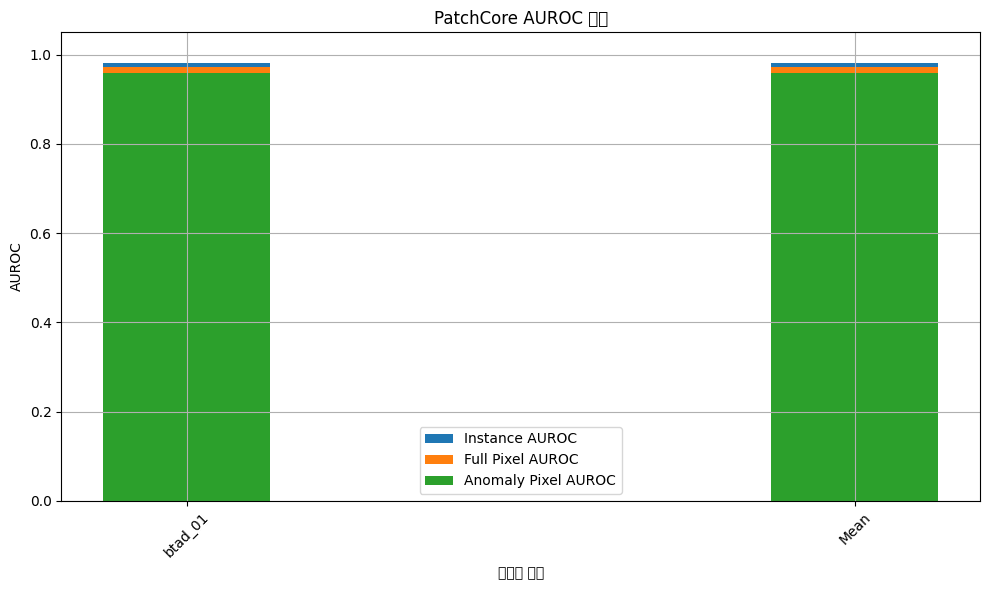

In [39]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대그래프 그리기
x = df['Row Names']
width = 0.25

plt.bar(x, df['instance_auroc'], width=width, label='Instance AUROC')
plt.bar(x, df['full_pixel_auroc'], width=width, label='Full Pixel AUROC', bottom=df['instance_auroc']*0)  # Trick to align
plt.bar(x, df['anomaly_pixel_auroc'], width=width, label='Anomaly Pixel AUROC', bottom=df['instance_auroc']*0)  # Same

# 그래프 꾸미기
plt.ylim(0.0, 1.05)
plt.title('PatchCore AUROC 결과')
plt.ylabel('AUROC')
plt.xlabel('클래스 이름')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from tabulate import tabulate

print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))


+-------------+------------------+--------------------+-----------------------+
| Row Names   |   instance_auroc |   full_pixel_auroc |   anomaly_pixel_auroc |
+=============+==================+====================+=======================+
| btad_01     |         0.980564 |           0.971501 |              0.958236 |
+-------------+------------------+--------------------+-----------------------+
| Mean        |         0.980564 |           0.971501 |              0.958236 |
+-------------+------------------+--------------------+-----------------------+


In [10]:
df = pd.read_csv("/home/lkmsdf159/patchcore-inspection/results/project/BTAD01_320_WR50_L2-3_0/results.csv")

print(df.head())

  Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0   btad_02        0.825333           0.96374             0.957222
1      Mean        0.825333           0.96374             0.957222


/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/464662434.py:20: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  plt.tight_layout()
/home/lkmsdf159/miniconda3/envs/patchcore/lib/python3

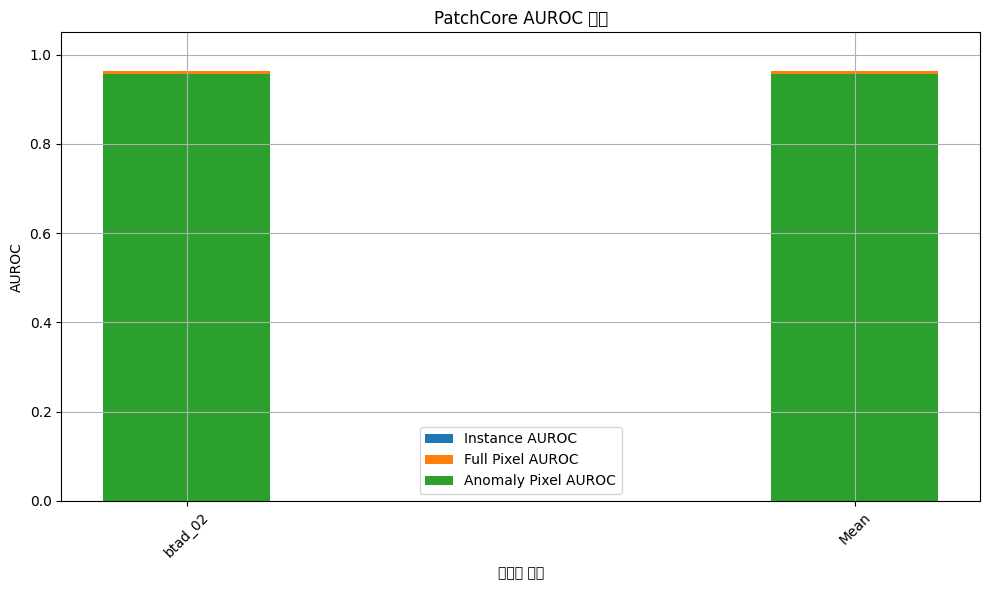

+-------------+------------------+--------------------+-----------------------+
| Row Names   |   instance_auroc |   full_pixel_auroc |   anomaly_pixel_auroc |
+=============+==================+====================+=======================+
| btad_02     |         0.825333 |            0.96374 |              0.957222 |
+-------------+------------------+--------------------+-----------------------+
| Mean        |         0.825333 |            0.96374 |              0.957222 |
+-------------+------------------+--------------------+-----------------------+


In [14]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대그래프 그리기
x = df['Row Names']
width = 0.25

plt.bar(x, df['instance_auroc'], width=width, label='Instance AUROC')
plt.bar(x, df['full_pixel_auroc'], width=width, label='Full Pixel AUROC', bottom=df['instance_auroc']*0)  # Trick to align
plt.bar(x, df['anomaly_pixel_auroc'], width=width, label='Anomaly Pixel AUROC', bottom=df['instance_auroc']*0)  # Same

# 그래프 꾸미기
plt.ylim(0.0, 1.05)
plt.title('PatchCore AUROC 결과')
plt.ylabel('AUROC')
plt.xlabel('클래스 이름')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))